##### This file presents the XGBoost  within tissue and cross tissue models used on the liver, heart and kidney datasets :
- The sequence only model for liver, heart and kidney dataset.
- The sequence plus DNA shape model for liver, heart and kidney dataset
- The sequence plus DNA shape plus histone modification model for liver, heart and kidney dataset.
- Cross validation for all three models.
- Cross tissue models 

In [1]:
# import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import re
import random
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import resample
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.datasets import make_classification
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn import preprocessing 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import model_selection



###  1.1 Liver Sequence only model

In [5]:
# Loading liver the bound and unbound E-box sequence only dataset

Pos_Seq= pd.read_csv('Positive_Liver_One_hot.csv', header = None)
Pos_Seq['Label'] = 'bound'

Neg_Seq = pd.read_csv('Negative_Liver_One_hot.csv', header = None)
Neg_Seq['Label'] = 'unbound'

Seq_Data = pd.concat([Pos_Seq,Neg_Seq],ignore_index=True)
Seq_Data = Seq_Data.reindex(np.random.permutation(Seq_Data.index))

Seq_Data['label']=pd.get_dummies(Seq_Data.Label, prefix='Label').iloc[:,:-1]
Seq_Data = Seq_Data.drop(['Label'], axis =1)

Seq_X = Seq_Data.drop('label', axis=1)
Seq_Y = Seq_Data['label']

In [6]:

X_train,X_test,y_train,y_test = train_test_split(Seq_X,Seq_Y,test_size=0.3, random_state=40210404)


In [7]:
# Sequence only xgboost model
Seq_xgb1 = XGBClassifier(max_depth=3, n_estimators =100, learning_rate=0.1, min_child_weight=1,use_label_encoder=False, colsample_bytree= 0.89, n_jobs =-1,  scale_pos_weight = 51, random_state= 40210404)
Seq_xgb1.fit(X_train,y_train)

[10:24:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.89,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=40210404, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=51, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [8]:

Seq_xgb1_pred = Seq_xgb1.predict_proba(X_test)[:,1]

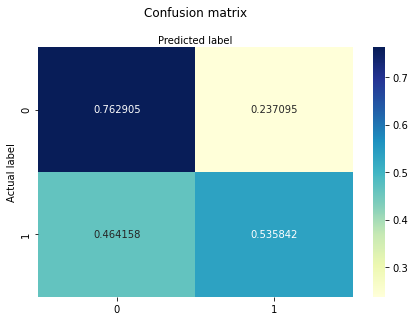

In [9]:
# Confusion Matrix

CM=metrics.confusion_matrix(y_test, Seq_xgb1_pred.round(), normalize='true')
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('LIVER_SEQ_ONLY_XGB_Confusion_Matrix.png')

In [10]:
# Classification Report

print(classification_report(y_test, Seq_xgb1_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     56876
           1       0.04      0.54      0.08      1116

    accuracy                           0.76     57992
   macro avg       0.52      0.65      0.47     57992
weighted avg       0.97      0.76      0.85     57992



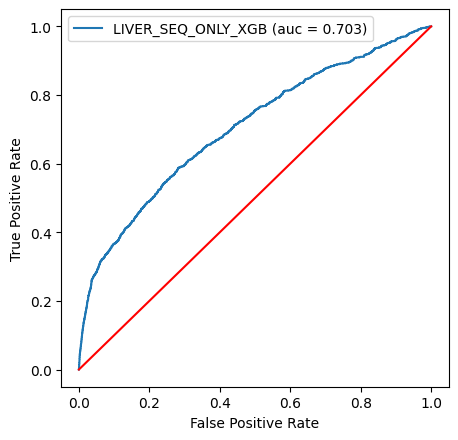

In [11]:
#Plotting the AUROC
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test,  Seq_xgb1_pred)
auc_xgb = auc(xgb_fpr, xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, label='LIVER_SEQ_ONLY_XGB (auc = %0.3f)' % auc_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.savefig('LIVER_SEQ_ONLY_XGB_AUC.png')
plt.show()

### 1.2 Liver sequence plus DNA shape model

In [12]:
# Loading liver the bound and unbound E-box sequence plus DNA shape dataset

Liver_SEQ_SHAPE_Pos= pd.read_csv('Pos_DNA_Five_Shape.csv')
Liver_SEQ_SHAPE_Pos['Label'] = 'bound'

Liver_SEQ_SHAPE_Neg= pd.read_csv('All_Neg_DNA_Five_Shape.csv')
Liver_SEQ_SHAPE_Neg['Label'] = 'unbound'

Liver_SEQ_SHAPE_Data= pd.concat([Liver_SEQ_SHAPE_Pos,Liver_SEQ_SHAPE_Neg], ignore_index=True)
Liver_SEQ_SHAPE_Data= Liver_SEQ_SHAPE_Data.reindex(np.random.permutation(Liver_SEQ_SHAPE_Data.index))

Liver_SEQ_SHAPE_Data['label']=pd.get_dummies(Liver_SEQ_SHAPE_Data.Label, prefix='Label').iloc[:,:-1]
Liver_SEQ_SHAPE_Data = Liver_SEQ_SHAPE_Data.drop(['Label'], axis =1)

Liver_SEQ_SHAPE_X= Liver_SEQ_SHAPE_Data.drop('label', axis=1)
Liver_SEQ_SHAPE_Y= Liver_SEQ_SHAPE_Data['label']

In [14]:
X_train,X_test,y_train,y_test = train_test_split(Liver_SEQ_SHAPE_X,Liver_SEQ_SHAPE_Y,test_size=0.3,random_state= 40210404)

In [15]:
#Model optimized parameters

liver_seq_shape_xgb_params= {
    'learning_rate': 0.10999997,
    'max_depth': 8,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':60 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 51,
    'subsample':0.899811392006158
    
    
}

In [16]:
# Sequence plus DNA shape xgboost model

liver_Seq_Shape_xgb = XGBClassifier(**liver_seq_shape_xgb_params, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
liver_Seq_Shape_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.10999997, max_delta_step=0.985654334, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=51,
              subsample=0.899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

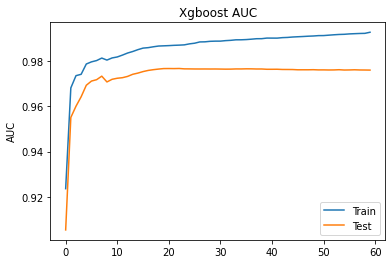

In [18]:
#Train_text evaluation


history = liver_Seq_Shape_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [19]:
liver_Seq_Shape_xgb_pred = liver_Seq_Shape_xgb.predict_proba(X_test)[:, 1]

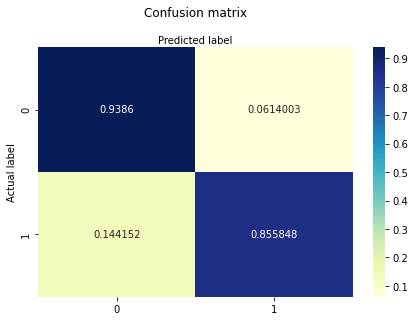

In [20]:
# Confusion matrix
CM=metrics.confusion_matrix(y_test, liver_Seq_Shape_xgb_pred.round(), normalize='true')
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('LIVER_SEQ_SHAPE_XGB_Confusion_Matrix.png')

In [21]:
#Model classification report
print(classification_report(y_test, liver_Seq_Shape_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56889
           1       0.21      0.86      0.34      1103

    accuracy                           0.94     57992
   macro avg       0.60      0.90      0.65     57992
weighted avg       0.98      0.94      0.96     57992



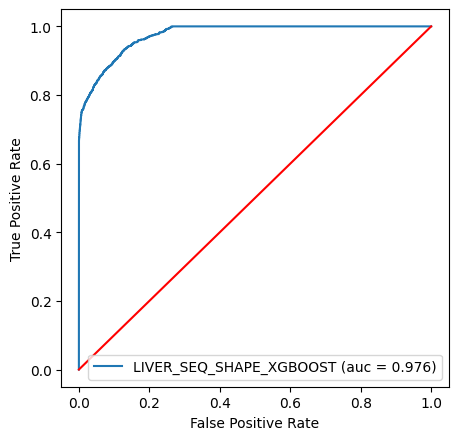

In [22]:
# Ploting the AUROC
liver_seq_shape_xgb_fpr, liver_seq_shape_xgb_tpr, threshold = roc_curve(y_test,liver_Seq_Shape_xgb_pred)
auc_liver_seq_shape_xgb = auc(liver_seq_shape_xgb_fpr, liver_seq_shape_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(liver_seq_shape_xgb_fpr, liver_seq_shape_xgb_tpr, label='LIVER_SEQ_SHAPE_XGBOOST (auc = %0.3f)' % auc_liver_seq_shape_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.savefig('LIVER_SEQ_SHAPE_XGB_AUC_CURVE.png')
plt.show()

In [23]:
#The AUPRC
liver_seq_shape_xgb_average_precision = average_precision_score(y_test,  liver_Seq_Shape_xgb_pred)

print('Average precision-recliver_seq_shape score: {0:0.2f}'.format(
      liver_seq_shape_xgb_average_precision))

Average precision-recliver_seq_shape score: 0.79


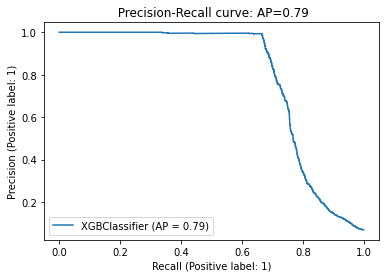

In [24]:
#Ploting the AUPRC
liver_seq_shape_xgb_Seq = plot_precision_recall_curve( liver_Seq_Shape_xgb, X_test, y_test)
liver_seq_shape_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(liver_seq_shape_xgb_average_precision))
plt.savefig('LIVER_SEQ_SHAPE_XGB_PR_CURVE.png')

### 1.3 Liver sequence plus DNA shape plus histone modification model

In [25]:
# Loading liver the bound and unbound E-box sequence plus DNA shape dataset

Positive_Liver_SSH = pd.read_csv('POSITIVE_LIVER_SEQSHAHIS_DATA.csv')
Positive_Liver_SSH['Label'] = 'bound'



Negative_Liver_SSH = pd.read_csv('NEGATIVE_LIVER_SEQSHAHIS_DATA.csv')
Negative_Liver_SSH = pd.DataFrame(Negative_Liver_SSH).fillna(0)
Negative_Liver_SSH.isnull().values.any()
Negative_Liver_SSH['Label'] = 'unbound'




LIVER_SSH_Data = pd.concat([Positive_Liver_SSH,Negative_Liver_SSH], ignore_index=True)
LIVER_SSH_Data = LIVER_SSH_Data.reindex(np.random.permutation(LIVER_SSH_Data.index))
LIVER_SSH_Data

LIVER_SSH_Data['label']=pd.get_dummies(LIVER_SSH_Data.Label, prefix='Label').iloc[:,:-1]
LIVER_SSH_Data = LIVER_SSH_Data.drop(['Label'], axis =1)
LIVER_SSH_Data

LIVER_SSH_Data_X = LIVER_SSH_Data.drop('label', axis=1)
LIVER_SSH_Data_Y = LIVER_SSH_Data['label']

In [27]:
X_train,X_test,y_train,y_test = train_test_split(LIVER_SSH_Data_X, LIVER_SSH_Data_Y, test_size=0.3, random_state= 40210404)

In [28]:
#Model optimized parameters

Histone_xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.130999997,
    'max_depth': 8,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':50 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 51,
    'subsample':0.899811392006158
    
    
}

In [29]:
# XGBoost model for sequence plus DNA shape plus histone modification
Histone_xgb = XGBClassifier(**Histone_xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
Histone_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.130999997, max_delta_step=0.985654334,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=51,
              subsample=0.899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

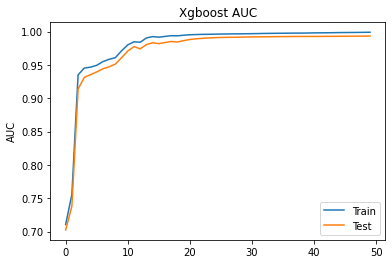

In [30]:
#Train_text evaluation

history = Histone_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [31]:
Histone_xgb_pred = Histone_xgb.predict_proba(X_test)[:, 1]

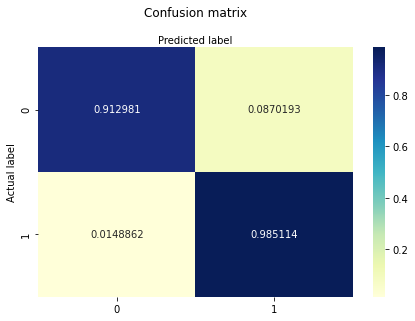

In [32]:
#Confusion matri
CM=metrics.confusion_matrix(y_test, Histone_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('LIVER_SSH_XGB_Confusion_Matrix.png')

In [33]:
#Clasification report
print(classification_report(y_test, Histone_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      8998
           1       0.59      0.99      0.74      1142

    accuracy                           0.92     10140
   macro avg       0.79      0.95      0.85     10140
weighted avg       0.95      0.92      0.93     10140



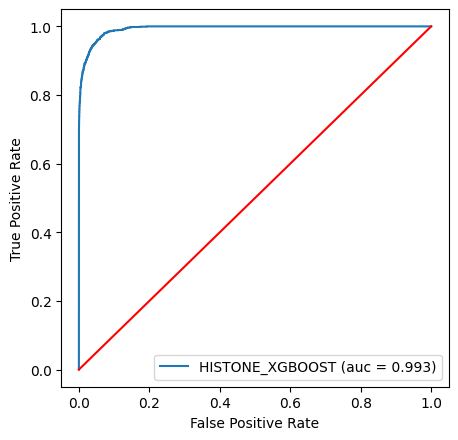

In [34]:
# Ploting the AUROC
histone_xgb_fpr, histone_xgb_tpr, threshold = roc_curve(y_test, Histone_xgb_pred)
auc_histone_xgb = auc(histone_xgb_fpr, histone_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(histone_xgb_fpr, histone_xgb_tpr, label='HISTONE_XGBOOST (auc = %0.3f)' % auc_histone_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.savefig('LIVER_SSH_XGB_AUC_CURVE.png')
plt.show()

In [35]:
#The AUPRC
histone_xgb_average_precision = average_precision_score(y_test,  Histone_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     histone_xgb_average_precision))

Average precision-recall score: 0.96


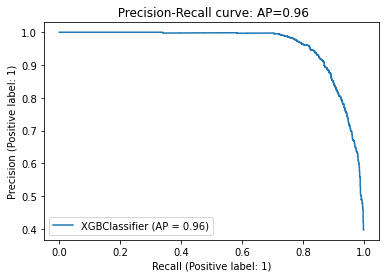

In [36]:
#Ploting the AUPRC
histone_xgb_Seq = plot_precision_recall_curve( Histone_xgb, X_test, y_test)
histone_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(histone_xgb_average_precision))
plt.savefig('LIVER_SSH_XGB_PR_CURVE.png')
plt.show()

### 1.4 Liver cross-validation for all models

In [37]:
def make_model(X, y, num_boosting_rounds, params):
    from xgboost import XGBClassifier
    
    model = XGBClassifier(
        n_estimators=num_boosting_rounds,
        **params,use_label_encoder=False
    )
    model.fit(X, y)

    
    return model

In [38]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold

def plot_roc(LIVER_SSH_Data, ax, ax2, n_estimators, params, color, features):
    cv = StratifiedKFold(n_splits=5)

    tprs = []
    recalls = []
    aucs = []
    auc_prcs = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_recalls = np.linspace(0,1,10001)
    X, y = LIVER_SSH_Data.drop('label', axis=1).values, LIVER_SSH_Data['label'].values

    for i, (train, test) in enumerate(cv.split(X, y)):
        print('----', i)
        m = make_model(X[train], y[train], n_estimators, params)
        #viz = plot_roc_curve(m, X[test], y[test],
        #                     name='ROC fold {}'.format(i),
        #                     alpha=0.3, lw=1, ax=ax)
        y_pred = m.predict_proba(X[test])[:,1]
        viz = roc_curve(y[test], y_pred)
        viz2 = precision_recall_curve(y[test], y_pred)
        interp_tpr = np.interp(mean_fpr, viz[0], viz[1])
        interp_tpr[0] = 0.0
        
        #import pdb; pdb.set_trace()
        interp_recall = np.interp(mean_recalls, viz2[0], viz2[1])
        interp_recall[0] = 1.0
        
        recalls.append(interp_recall)
        tprs.append(interp_tpr)
        auc_prcs.append(auc(viz2[1], viz2[0]))
        aucs.append(auc(viz[0], viz[1]))
        print('AUROCS: ', aucs)
        print('AUPRCS: ', auc_prcs)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            alpha=.8)

    mean_recall = np.mean(recalls, axis=0)
    mean_recall[-1] = 0.0
    mean_auprc = auc(mean_recalls, mean_recall)
    std_auprc = np.std(auc_prcs)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color=color,
            label=r'%s (AUROC = %0.2f $\pm$ %0.2f)' % (features, mean_auc, std_auc),
            lw=2, alpha=.8)

    ax2.plot(mean_recalls, mean_recall, color=color,
        label=r'%s (AUPRC = %0.2f $\pm$ %0.2f)' % (features, mean_auprc, std_auprc),
        lw=2, alpha=.8)

    
    std_tpr = 1.96*np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2)
                    #label=r'$\pm$ 1 std. dev.')

    std_recall = 1.96*np.std(recalls, axis=0)
    recalls_upper = np.minimum(mean_recall + std_recall, 1)
    recalls_lower = np.maximum(mean_recall - std_recall, 0)
    ax2.fill_between(mean_recalls, recalls_lower, recalls_upper, color=color, alpha=.2)
                    #label=r'$\pm$ 1 std. dev.')

        
    #ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
    #       title="Receiver operating characteristic example")
    #ax.legend(loc="lower right")
    #plt.show()

sequence
---- 0
[10:50:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROCS:  [0.703685018124186]
AUPRCS:  [0.08429402280676815]
---- 1
[10:50:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROCS:  [0.703685018124186, 0.7207578072616898]
AUPRCS:  [0.08429402280676815, 0.09312393824478102]
---- 2
[10:50:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROCS:  [0.703685018124186, 0.7207578072616898, 0.71

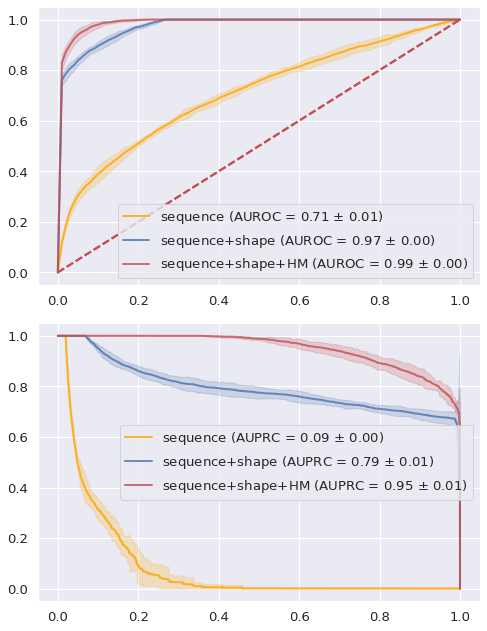

In [39]:
sns.set(font_scale=1.2)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))
fig.set_size_inches(7, 9)
print('sequence')
# results for best CV
n_estimators = 100
params =  {"max_depth":5,  "learning_rate":0.1, "min_child_weight":1, "colsample_bytree": 0.89, "n_jobs" :-1,  "scale_pos_weight":51, "random_state": 40210404}
plot_roc(Seq_Data, ax1, ax2, n_estimators, params, 'orange', 'sequence')

print('sequence+shape')
# results for best CV
n_estimators = 70
params =  {"max_depth": 3, "min_child_weight": 1, 'learning_rate': 0.10999997, "subsample": 0.899811392006158, "colsample_bytree":0.9234243, 'random_state':40210404, "max_delta_step": 1, 'scale_pos_weight': 51, "n_jobs": -1 }
plot_roc(Liver_SEQ_SHAPE_Data, ax1, ax2, n_estimators, params, 'b', 'sequence+shape')

print('sequence+shape+histone')
# results for best CV
n_estimators = 40
params =  { "learning_rate": 0.10993245,"max_depth": 4, "min_child_weight": 1, 'subsample':0.8899811392006158, "colsample_bytree": 0.9200000, 'random_state':40210894, 'scale_pos_weight': 51, "max_delta_step":0.91654334,"n_jobs": -1 }
plot_roc(LIVER_SSH_Data, ax1, ax2, n_estimators, params, 'r', 'sequence+shape+HM')



ax1.legend(loc='lower right')
ax2.legend(loc='center right')
plt.tight_layout()
plt.savefig('LIVER_FINAL_PERFORMANCE_METRICS.png')
plt.show()

### 2.1 Heart Sequence only model

In [40]:
heart_Pos_Seq= pd.read_csv('Positive_heart_One_hot.csv', header = None)
heart_Pos_Seq['Label'] = 'bound'

heart_Neg_Seq = pd.read_csv('Negative_heart_One_hot.csv', header = None)
heart_Neg_Seq['Label'] = 'unbound'

heart_Seq_Data = pd.concat([heart_Pos_Seq,heart_Neg_Seq],ignore_index=True)
heart_Seq_Data = heart_Seq_Data.reindex(np.random.permutation(heart_Seq_Data.index))

heart_Seq_Data['label']=pd.get_dummies(heart_Seq_Data.Label, prefix='Label').iloc[:,:-1]
heart_Seq_Data = heart_Seq_Data.drop(['Label'], axis =1)


heart_Seq_X = heart_Seq_Data.drop('label', axis=1)
heart_Seq_Y = heart_Seq_Data['label']

In [41]:
X_train,X_test,y_train,y_test = train_test_split(heart_Seq_X,heart_Seq_Y,test_size=0.3, random_state=40210404)

In [42]:
#Sequence only xgboost model
heart_Seq_xgb1 = XGBClassifier(max_depth=3, n_estimators =100, learning_rate=0.1, min_child_weight=1,use_label_encoder=False, colsample_bytree= 0.89,n_jobs =-1,  scale_pos_weight = 223, random_state= 40210404)
heart_Seq_xgb1.fit(X_train,y_train)

[11:15:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.89,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=40210404, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=223, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [43]:

heart_Seq_xgb1_pred = heart_Seq_xgb1.predict_proba(X_test)[:,1]

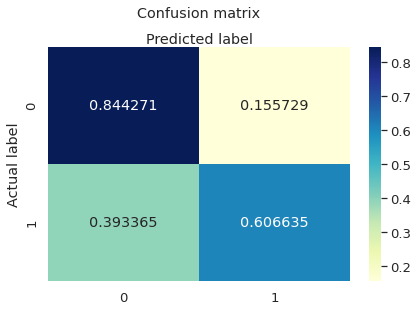

In [44]:
#Confusion matrix
CM=metrics.confusion_matrix(y_test, heart_Seq_xgb1_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('HEART_SEQ_ONLY_XGB_Confusion_Matrix.png')

In [45]:
# Classification Report
print(classification_report(y_test, heart_Seq_xgb1_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     87524
           1       0.02      0.61      0.04       422

    accuracy                           0.84     87946
   macro avg       0.51      0.73      0.48     87946
weighted avg       0.99      0.84      0.91     87946



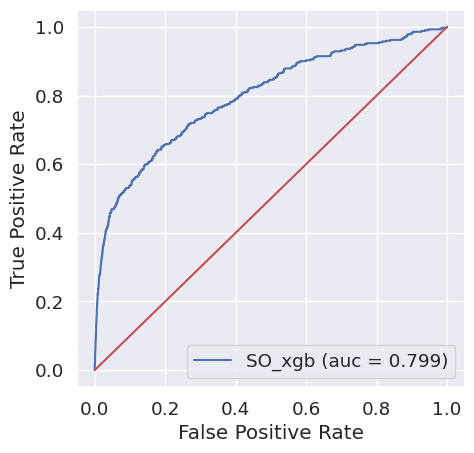

In [46]:
##Plotting the AUROC
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test,  heart_Seq_xgb1_pred)
auc_xgb = auc(xgb_fpr, xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, label='SO_xgb (auc = %0.3f)' % auc_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.savefig('HEART_SEQ_ONLY_XGB_AUC.png')
plt.show()

In [47]:
#AUPRC
xgb_average_precision = average_precision_score(y_test,  heart_Seq_xgb1_pred)
print('Average precision-recall score: {0:0.2f}'.format(
      xgb_average_precision))

Average precision-recall score: 0.06


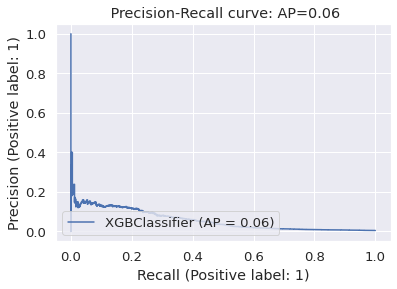

In [48]:
#Ploting the AUPRC
xgb_Seq_log = plot_precision_recall_curve(heart_Seq_xgb1, X_test, y_test)
xgb_Seq_log.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(xgb_average_precision))
plt.savefig('HEART_SEQ_ONLY_XGB_PR_CURVE.png')
plt.show()

### 2.2 Heart sequence plus DNA shape model

In [49]:
# Loading heart the bound and unbound E-box sequence plus DNA shape dataset

Positive_heart_Seq_Sha = pd.read_csv('POSITIVE_HEART_SEQ_SHAP_DATA.csv')
Positive_heart_Seq_Sha['Label'] = 'bound'

Negative_heart_Seq_Sha = pd.read_csv('NEGATIVE_HEART_SEQ_SHAP_DATA.csv')
Negative_heart_Seq_Sha['Label'] = 'unbound'

heart_Seq_Sha_Data = pd.concat([Positive_heart_Seq_Sha,Negative_heart_Seq_Sha], ignore_index=True)
heart_Seq_Sha_Data = heart_Seq_Sha_Data.reindex(np.random.permutation(heart_Seq_Sha_Data.index))


heart_Seq_Sha_Data['label']=pd.get_dummies(heart_Seq_Sha_Data.Label, prefix='Label').iloc[:,:-1]
heart_Seq_Sha_Data = heart_Seq_Sha_Data.drop(['Label'], axis =1)


heart_Seq_Sha_Data_X = heart_Seq_Sha_Data.drop('label', axis=1)
heart_Seq_Sha_Data_Y = heart_Seq_Sha_Data['label']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(heart_Seq_Sha_Data_X, heart_Seq_Sha_Data_Y, test_size=0.3, random_state= 40210404)

In [50]:
#Model optimized parameters
xgb_params_fixed = {
     'learning_rate': 0.1080023,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':70 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 223,
    'subsample':0.899811392006158
    
    
    
}

In [51]:
# Sequence plus DNA shape xgboost model
heart_seq_sha_xgb = XGBClassifier(**xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
heart_seq_sha_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1080023, max_delta_step=0.985654334, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=70, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=223,
              subsample=0.899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

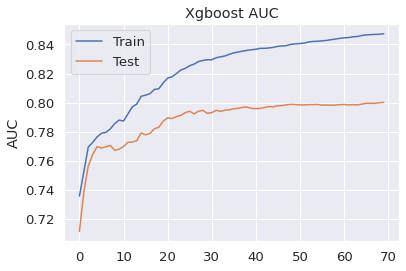

In [52]:
#Train_text evaluation

history = heart_seq_sha_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [53]:
heart_seq_sha_xgb_pred = heart_seq_sha_xgb.predict_proba(X_test)[:, 1]

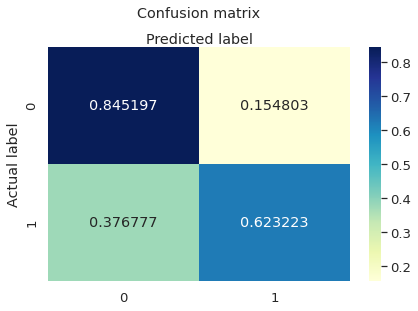

In [54]:
#Confusion matrix

CM=metrics.confusion_matrix(y_test, heart_seq_sha_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('HEART_SEQ_SHAPE_XGB_Confusion_Matrix.png')

In [55]:
#Model classification report
print(classification_report(y_test, heart_seq_sha_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     87524
           1       0.02      0.62      0.04       422

    accuracy                           0.84     87946
   macro avg       0.51      0.73      0.48     87946
weighted avg       0.99      0.84      0.91     87946



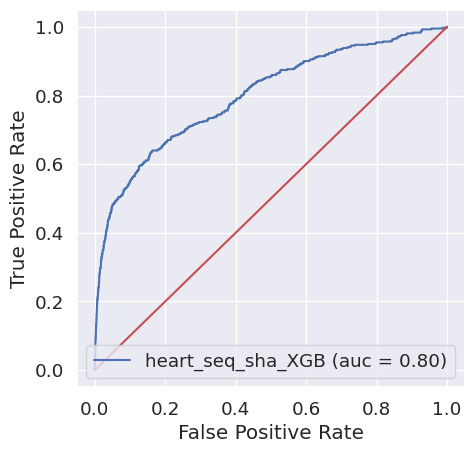

In [57]:
# Ploting the AUROC
heart_seq_sha_xgb_fpr, heart_seq_sha_xgb_tpr, threshold = roc_curve(y_test, heart_seq_sha_xgb_pred)
auc_heart_seq_sha_xgb = auc(heart_seq_sha_xgb_fpr, heart_seq_sha_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(heart_seq_sha_xgb_fpr, heart_seq_sha_xgb_tpr, label='heart_seq_sha_XGB (auc = %0.2f)' % auc_heart_seq_sha_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.savefig('HEART_SEQ_SHAPE_XGB_AUC_CURVE.png')
plt.show()

In [58]:
#The AUPRC
heart_seq_sha_xgb_average_precision = average_precision_score(y_test,  heart_seq_sha_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     heart_seq_sha_xgb_average_precision))

Average precision-recall score: 0.06


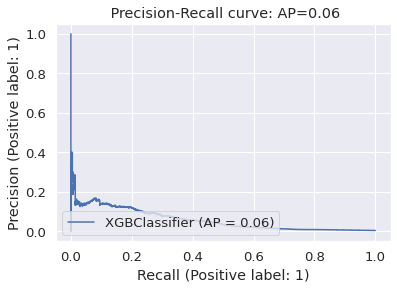

In [59]:
#Ploting the AUPRC
heart_seq_sha_xgb_Seq = plot_precision_recall_curve( heart_seq_sha_xgb, X_test, y_test)
heart_seq_sha_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(heart_seq_sha_xgb_average_precision))
plt.savefig('HEART_SEQ_SHAPE_XGB_PR_CURVE.png')
plt.show()

### 2.3 Heart sequence plus DNA shape plus histone modification model

In [60]:
Positive_HEART_SSH = pd.read_csv('POSITIVE_HEART_SEQSHAHIST.csv')
Positive_HEART_SSH['Label'] = 'Bound'

Negative_HEART_SSH = pd.read_csv('NEGATIVE_HEART_SEQSHAHIST.csv')
Negative_HEART_SSH['Label'] = 'Unbound'

HEART_three_Data = pd.concat([Positive_HEART_SSH,Negative_HEART_SSH], ignore_index=True)
HEART_three_Data = HEART_three_Data.reindex(np.random.permutation(HEART_three_Data.index))

HEART_three_Data['label']=pd.get_dummies(HEART_three_Data.Label, prefix='Label').iloc[:,:-1]
HEART_three_Data = HEART_three_Data.drop(['Label'], axis =1)

HEART_three_Data_X = HEART_three_Data.drop('label', axis=1)
HEART_three_Data_Y = HEART_three_Data['label']

In [61]:
X_train,X_test,y_train,y_test = train_test_split(HEART_three_Data_X,HEART_three_Data_Y,test_size=0.3, random_state= 40210404)

In [62]:
#Model optimized parameters
Histone_xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.2997897,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':40 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 223,
    'colsample_bylevel': 0.85797,
    'random_state': 40210404,
    'subsample':0.8899811392006158
    
    
    
}

In [63]:
# XGBoost model for sequence plus DNA shape plus histone modification
Histone_heart_xgb = XGBClassifier(**Histone_xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
Histone_heart_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85797,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2997897, max_delta_step=0.985654334, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=40210404, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=223, subsample=0.8899811392006158,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

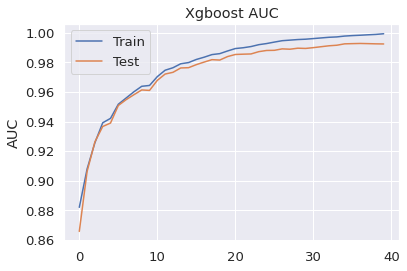

In [64]:
#Train_text evaluation
history = Histone_heart_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [65]:
Histone_heart_xgb_pred = Histone_heart_xgb.predict_proba(X_test)[:, 1]

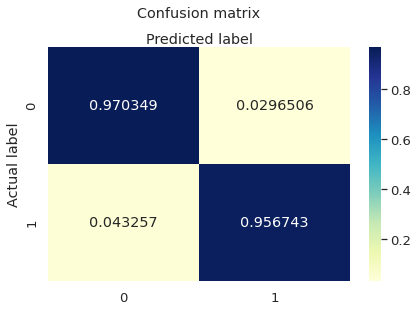

In [66]:
#Confusion matrix
CM=metrics.confusion_matrix(y_test, Histone_heart_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('HEART_SSH_XGB_Confusion_Matrix.png')

In [67]:
#Clasification report
print(classification_report(y_test, Histone_heart_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     87553
           1       0.13      0.96      0.22       393

    accuracy                           0.97     87946
   macro avg       0.56      0.96      0.60     87946
weighted avg       1.00      0.97      0.98     87946



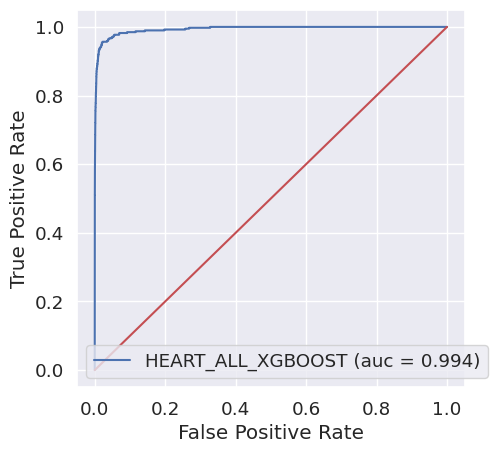

In [68]:
# Ploting the AUROC
histone_heart_xgb_fpr, histone_heart_xgb_tpr, threshold = roc_curve(y_test, Histone_heart_xgb_pred)
auc_histone_heart_xgb = auc(histone_heart_xgb_fpr, histone_heart_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(histone_heart_xgb_fpr, histone_heart_xgb_tpr, label='HEART_ALL_XGBOOST (auc = %0.3f)' % auc_histone_heart_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.savefig('HEART_SSH_XGB_AUC_CURVE.png')
plt.show()

In [69]:
#The AUPRC
histone_heart_xgb_average_precision = average_precision_score(y_test,  Histone_heart_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     histone_heart_xgb_average_precision))

Average precision-recall score: 0.78


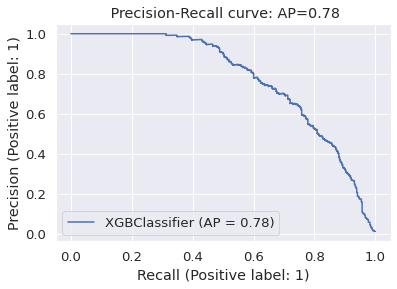

In [70]:
#Ploting the AUPRC
histone_heart_xgb_Seq = plot_precision_recall_curve( Histone_heart_xgb, X_test, y_test)
histone_heart_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(histone_heart_xgb_average_precision ))
plt.savefig('HEART_SSH_XGB_PR_CURVE.png')
plt.show()

### 2.4 Heart cross-validation for all models

In [71]:
def make_model(X, y, num_boosting_rounds, params):
    from xgboost import XGBClassifier
    
    model = XGBClassifier(
        n_estimators=num_boosting_rounds,
        **params,use_label_encoder=False
    )
    model.fit(X, y)

    
    return model

In [72]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold

def plot_roc(HEART_three_Data, ax, ax2, n_estimators, params, color, features):
    cv = StratifiedKFold(n_splits=5)

    tprs = []
    recalls = []
    aucs = []
    auc_prcs = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_recalls = np.linspace(0,1,10001)
    X, y = HEART_three_Data.drop('label', axis=1).values, HEART_three_Data['label'].values

    for i, (train, test) in enumerate(cv.split(X, y)):
        print('----', i)
        m = make_model(X[train], y[train], n_estimators, params)
        #viz = plot_roc_curve(m, X[test], y[test],
        #                     name='ROC fold {}'.format(i),
        #                     alpha=0.3, lw=1, ax=ax)
        y_pred = m.predict_proba(X[test])[:,1]
        viz = roc_curve(y[test], y_pred)
        viz2 = precision_recall_curve(y[test], y_pred)
        interp_tpr = np.interp(mean_fpr, viz[0], viz[1])
        interp_tpr[0] = 0.0
        
        #import pdb; pdb.set_trace()
        interp_recall = np.interp(mean_recalls, viz2[0], viz2[1])
        interp_recall[0] = 1.0
        
        recalls.append(interp_recall)
        tprs.append(interp_tpr)
        auc_prcs.append(auc(viz2[1], viz2[0]))
        aucs.append(auc(viz[0], viz[1]))
        print('AUROCS: ', aucs)
        print('AUPRCS: ', auc_prcs)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            alpha=.8)

    mean_recall = np.mean(recalls, axis=0)
    mean_recall[-1] = 0.0
    mean_auprc = auc(mean_recalls, mean_recall)
    std_auprc = np.std(auc_prcs)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color=color,
            label=r'%s (AUROC = %0.2f $\pm$ %0.2f)' % (features, mean_auc, std_auc),
            lw=2, alpha=.8)

    ax2.plot(mean_recalls, mean_recall, color=color,
        label=r'%s (AUPRC = %0.2f $\pm$ %0.2f)' % (features, mean_auprc, std_auprc),
        lw=2, alpha=.8)

    
    std_tpr = 1.96*np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2)
                    #label=r'$\pm$ 1 std. dev.')

    std_recall = 1.96*np.std(recalls, axis=0)
    recalls_upper = np.minimum(mean_recall + std_recall, 1)
    recalls_lower = np.maximum(mean_recall - std_recall, 0)
    ax2.fill_between(mean_recalls, recalls_lower, recalls_upper, color=color, alpha=.2)
                    #label=r'$\pm$ 1 std. dev.')

        
    #ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
    #       title="Receiver operating characteristic example")
    #ax.legend(loc="lower right")
    #plt.show()

sequence
---- 0
[11:32:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROCS:  [0.8101886196822259]
AUPRCS:  [0.06261308548868944]
---- 1
[11:32:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROCS:  [0.8101886196822259, 0.815409558234941]
AUPRCS:  [0.06261308548868944, 0.0707220603083678]
---- 2
[11:32:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROCS:  [0.8101886196822259, 0.815409558234941, 0.81

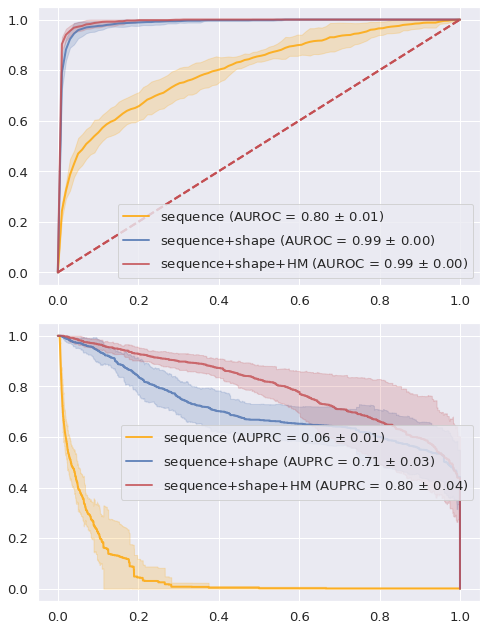

In [73]:
sns.set(font_scale=1.2)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))
fig.set_size_inches(7, 9)
print('sequence')
# results for best CV
n_estimators = 100
params =  {"max_depth":3,  "learning_rate":0.1, "min_child_weight":1, "colsample_bytree": 0.89, "n_jobs" :-1,  "scale_pos_weight":223, "random_state": 40210404}
plot_roc(heart_Seq_Data, ax1, ax2, n_estimators, params, 'orange', 'sequence')

print('sequence+shape')
# results for best CV
n_estimators = 70
params =  {"max_depth": 3, "min_child_weight": 1, 'learning_rate': 0.1080023, "subsample": 0.899811392006158, "colsample_bytree":0.9234243, 'random_state':40210404, "max_delta_step": 1, 'scale_pos_weight': 223, "n_jobs": -1 }
plot_roc(heart_Seq_Sha_Data, ax1, ax2, n_estimators, params, 'b', 'sequence+shape')

print('sequence+shape+histone')
# results for best CV
n_estimators = 40
params =  { "learning_rate": 0.2997897,"max_depth": 3, "min_child_weight": 1, 'subsample':0.8899811392006158, "colsample_bytree":0.9234243, 'random_state':40210894, 'scale_pos_weight': 223, "max_delta_step":0.91654334,"n_jobs": -1 }
plot_roc(HEART_three_Data, ax1, ax2, n_estimators, params, 'r', 'sequence+shape+HM')



ax1.legend(loc='lower right')
ax2.legend(loc='center right')
plt.tight_layout()
plt.savefig('HEART_FINAL_PERFORMANCE_METRICS.png')
plt.show()

### 3.1 Kidney Sequence only model

In [75]:
# Loading kidney the bound and unbound E-box sequence only dataset
Kid_Pos_Seq= pd.read_csv('Positive_Kidney_One_hot.csv', header = None)
Kid_Pos_Seq['Label'] = 'bound'


Kid_Neg_Seq = pd.read_csv('Negative_Kidney_One_hot.csv', header = None)
Kid_Neg_Seq['Label'] = 'unbound'

Kid_Seq_Data = pd.concat([Kid_Pos_Seq,Kid_Neg_Seq],ignore_index=True)
Kid_Seq_Data = Kid_Seq_Data.reindex(np.random.permutation(Kid_Seq_Data.index))

Kid_Seq_Data['label']=pd.get_dummies(Kid_Seq_Data.Label, prefix='Label').iloc[:,:-1]
Kid_Seq_Data = Kid_Seq_Data.drop(['Label'], axis =1)


Kid_Seq_X = Kid_Seq_Data.drop('label', axis=1)
Kid_Seq_Y = Kid_Seq_Data['label']

In [76]:
X_train,X_test,y_train,y_test = train_test_split(Kid_Seq_X,Kid_Seq_Y,test_size=0.3, random_state=40210404)

In [77]:
# Sequence only xgboost model
kid_Seq_xgb1 = XGBClassifier(max_depth=3, n_estimators =100, learning_rate=0.1, min_child_weight=1, scale_pos_weight=81, use_label_encoder=False, colsample_bytree= 0.89,n_jobs =-1, random_state= 40210404)
kid_Seq_xgb1.fit(X_train,y_train)


[11:34:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.89,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=40210404, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=81, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [80]:

kid_Seq_xgb1_pred = kid_Seq_xgb1.predict_proba(X_test)[:,1]

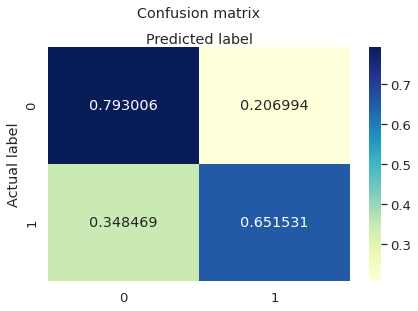

In [81]:
# Confusion Matrix
CM=metrics.confusion_matrix(y_test, kid_Seq_xgb1_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('KIDNEY_SEQ_ONLY_XGB_Confusion_Matrix.png')

In [82]:
# Classification Report
print(classification_report(y_test, kid_Seq_xgb1_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     78640
           1       0.04      0.65      0.07       947

    accuracy                           0.79     79587
   macro avg       0.52      0.72      0.48     79587
weighted avg       0.98      0.79      0.87     79587



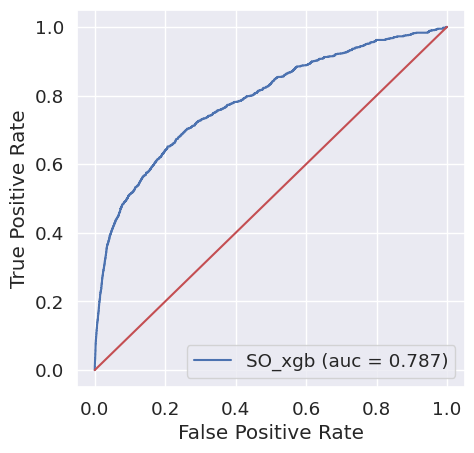

In [83]:
#Plotting the AUROC
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test,  kid_Seq_xgb1_pred)
auc_xgb = auc(xgb_fpr, xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, label='SO_xgb (auc = %0.3f)' % auc_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.savefig('KIDNEY_SEQ_ONLY_XGB_AUC.png')
plt.show()

In [84]:
#The AUPRC
xgb_average_precision = average_precision_score(y_test,  kid_Seq_xgb1_pred)
print('Average precision-recall score: {0:0.2f}'.format(
      xgb_average_precision))

Average precision-recall score: 0.10


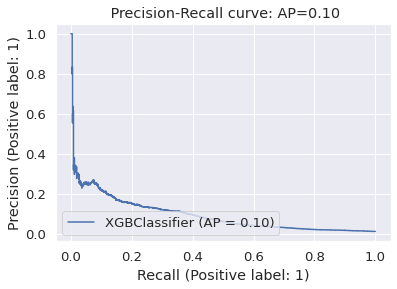

In [85]:
#Ploting the AUPRC 
xgb_Seq_log = plot_precision_recall_curve(kid_Seq_xgb1, X_test, y_test)
xgb_Seq_log.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(xgb_average_precision))
plt.savefig('KIDNEY_SEQ_ONLY_XGB_PR_CURVE.png')
plt.show()

### 3.2 Kidney sequence plus DNA shape model

In [86]:
# Loading kidney the bound and unbound E-box sequence plus DNA shape dataset

Positive_Kidney_Seq_Sha = pd.read_csv('POSITIVE_KIDNEY_SEQSHAPE_DATA.csv')
Positive_Kidney_Seq_Sha['Label'] = 'bound'

Negative_Kidney_Seq_Sha = pd.read_csv('NEGATIVE_KIDNEY_SEQ_SHAPE_DATA.csv')
Negative_Kidney_Seq_Sha['Label'] = 'unbound'

Kidney_Seq_Sha_Data = pd.concat([Positive_Kidney_Seq_Sha,Negative_Kidney_Seq_Sha], ignore_index=True)
Kidney_Seq_Sha_Data = Kidney_Seq_Sha_Data.reindex(np.random.permutation(Kidney_Seq_Sha_Data.index))
Kidney_Seq_Sha_Data

Kidney_Seq_Sha_Data['label']=pd.get_dummies(Kidney_Seq_Sha_Data.Label, prefix='Label').iloc[:,:-1]
Kidney_Seq_Sha_Data = Kidney_Seq_Sha_Data.drop(['Label'], axis =1)
Kidney_Seq_Sha_Data

Kidney_Seq_Sha_Data_X = Kidney_Seq_Sha_Data.drop('label', axis=1)
Kidney_Seq_Sha_Data_Y = Kidney_Seq_Sha_Data['label']

In [87]:
X_train,X_test,y_train,y_test = train_test_split(Kidney_Seq_Sha_Data_X,Kidney_Seq_Sha_Data_Y,test_size=0.3, random_state=40210404)

In [88]:
#Model optimized parameters
xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.100997897,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':70 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 81,
    'colsample_bylevel': 0.85797,
    'subsample':0.8899811392006158
    
    
    
}

In [89]:
# Sequence plus DNA shape xgboost model
kid_seq_sha_xgb = XGBClassifier(**xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
kid_seq_sha_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85797,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100997897, max_delta_step=0.985654334,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=81,
              subsample=0.8899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

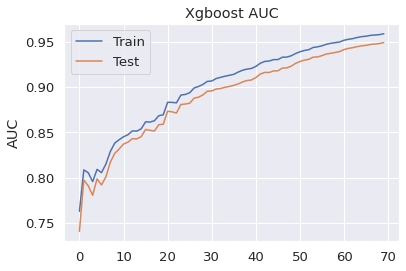

In [90]:
#Train_text evaluation
history = kid_seq_sha_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [91]:
kid_seq_sha_xgb_pred = kid_seq_sha_xgb.predict_proba(X_test)[:, 1]

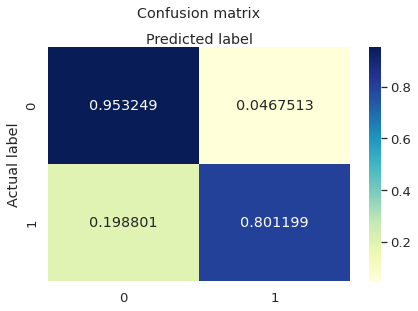

In [92]:
# Confusion matrix

CM=metrics.confusion_matrix(y_test, kid_seq_sha_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('KIDNEY_SEQ_SHAPE_XGB_Confusion_Matrix.png')

In [93]:
#Model classification report
print(classification_report(y_test, kid_seq_sha_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     78586
           1       0.18      0.80      0.29      1001

    accuracy                           0.95     79587
   macro avg       0.59      0.88      0.63     79587
weighted avg       0.99      0.95      0.97     79587



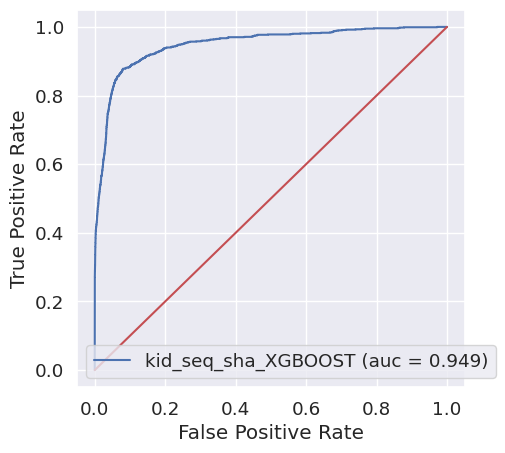

In [94]:
# Ploting the AUROC
kid_seq_sha_xgb_fpr, kid_seq_sha_xgb_tpr, threshold = roc_curve(y_test, kid_seq_sha_xgb_pred)
auc_kid_seq_sha_xgb = auc(kid_seq_sha_xgb_fpr, kid_seq_sha_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(kid_seq_sha_xgb_fpr, kid_seq_sha_xgb_tpr, label='kid_seq_sha_XGBOOST (auc = %0.3f)' % auc_kid_seq_sha_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.savefig('KIDNEY_SEQ_SHAPE_XGB_AUC_CURVE.png')
plt.show()

In [95]:
#The AUPRC
kid_seq_sha_xgb_average_precision = average_precision_score(y_test,  kid_seq_sha_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     kid_seq_sha_xgb_average_precision))

Average precision-recall score: 0.51


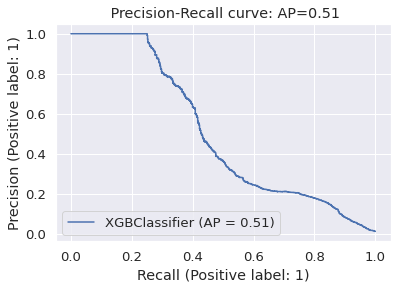

In [96]:
#Ploting the AUPRC
kid_seq_sha_xgb_Seq = plot_precision_recall_curve( kid_seq_sha_xgb, X_test, y_test)
kid_seq_sha_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(kid_seq_sha_xgb_average_precision))
plt.savefig('KIDNEY_SEQ_SHAPE_XGB_PR_CURVE.png')
plt.show()

### 3.3 Liver sequence plus DNA shape plus histone modification model

In [97]:
# Loading liver the bound and unbound E-box sequence plus DNA shape dataset

Positive_KIDNEY_SSH = pd.read_csv('POSITIVE_KIDNEY_SEQSHAHIST_DATA.csv')
Positive_KIDNEY_SSH['Label'] = 'Bound'

Negative_KIDNEY_SSH = pd.read_csv('NEGATIVE_KIDNEY_SEQSHAHIST_DATA.csv')
Negative_KIDNEY_SSH = pd.DataFrame(Negative_KIDNEY_SSH).fillna(0)
Negative_KIDNEY_SSH['Label'] = 'Unbound'

KIDNEY_three_Data = pd.concat([Positive_KIDNEY_SSH,Negative_KIDNEY_SSH], ignore_index=True)
KIDNEY_three_Data = KIDNEY_three_Data.reindex(np.random.permutation(KIDNEY_three_Data.index))
KIDNEY_three_Data


KIDNEY_three_Data['label']=pd.get_dummies(KIDNEY_three_Data.Label, prefix='Label').iloc[:,:-1]
KIDNEY_three_Data = KIDNEY_three_Data.drop(['Label'], axis =1)


KIDNEY_three_Data_X = KIDNEY_three_Data.drop('label', axis=1)
KIDNEY_three_Data_Y = KIDNEY_three_Data['label']

In [98]:
X_train,X_test,y_train,y_test = train_test_split(KIDNEY_three_Data_X, KIDNEY_three_Data_Y, test_size=0.3, random_state= 40210404)

In [99]:
#Model optimized parameters
Histone_xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.10997897,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':100 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 81,
    'colsample_bylevel': 0.85797,
    'subsample':0.8899811392006158
    
    
    
}

In [100]:
# XGBoost model for sequence plus DNA shape plus histone modification
Histone_kidney_xgb = XGBClassifier(**Histone_xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
Histone_kidney_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85797,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.10997897, max_delta_step=0.985654334, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=81, subsample=0.8899811392006158,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

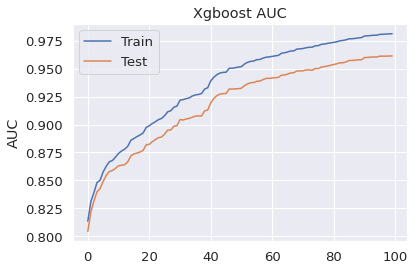

In [101]:
#Train_text evaluation
history = Histone_kidney_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [102]:
Histone_kidney_xgb_pred = Histone_kidney_xgb.predict_proba(X_test)[:, 1]

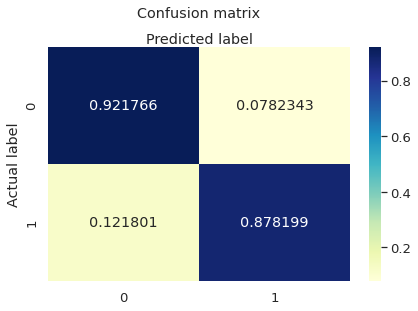

In [103]:
#Confusion matrix

CM=metrics.confusion_matrix(y_test, Histone_kidney_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('KIDNEY_SSH_XGB_Confusion_Matrix.png')

In [104]:
#Clasification report
print(classification_report(y_test, Histone_kidney_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     78610
           1       0.12      0.88      0.21       977

    accuracy                           0.92     79587
   macro avg       0.56      0.90      0.59     79587
weighted avg       0.99      0.92      0.95     79587



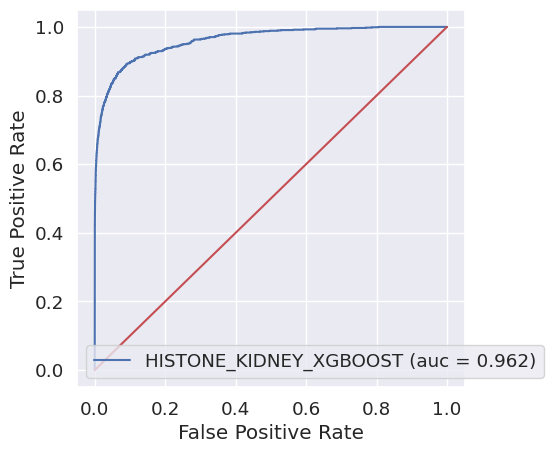

In [105]:
# Ploting the AUROC
histone_kidney_xgb_fpr, histone_kidney_xgb_tpr, threshold = roc_curve(y_test, Histone_kidney_xgb_pred)
auc_histone_kidney_xgb = auc(histone_kidney_xgb_fpr, histone_kidney_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(histone_kidney_xgb_fpr, histone_kidney_xgb_tpr, label='HISTONE_KIDNEY_XGBOOST (auc = %0.3f)' % auc_histone_kidney_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.savefig('KIDNEY_SSH_XGB_AUC_CURVE.png')
plt.show()

In [106]:
#The AUPRC
histone_kidney_xgb_average_precision = average_precision_score(y_test,  Histone_kidney_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     histone_kidney_xgb_average_precision))

Average precision-recall score: 0.67


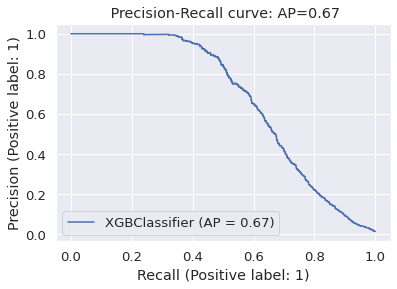

In [107]:
#Ploting the AUPRC
histone_kidney_xgb_Seq = plot_precision_recall_curve( Histone_kidney_xgb, X_test, y_test)
histone_kidney_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(histone_kidney_xgb_average_precision))
plt.savefig('KIDNEY_SSH_XGB_PR_CURVE.png')
plt.show()

### 3.4 Liver cross-validation for all models

In [108]:
def make_model(X, y, num_boosting_rounds, params):
    from xgboost import XGBClassifier
    
    model = XGBClassifier(
        n_estimators=num_boosting_rounds,
        **params,use_label_encoder=False
    )
    model.fit(X, y)

    
    return model

In [109]:
KIDNEY_three_Data

Seq-4_A  Seq-4_C  Seq-4_G  Seq-4_T  Seq-3_A  Seq-3_C  Seq-3_G  \
259946        0        1        0        0        0        1        0   
253552        0        0        1        0        1        0        0   
38023         0        0        0        1        0        1        0   
240810        0        0        0        1        1        0        0   
165135        0        0        1        0        1        0        0   
...         ...      ...      ...      ...      ...      ...      ...   
132074        0        1        0        0        0        1        0   
245404        0        0        0        1        0        0        0   
24347         0        1        0        0        0        0        0   
59443         1        0        0        0        1        0        0   
109345        0        0        1        0        0        0        0   

        Seq-3_T  Seq-2_A  Seq-2_C  ...  H3K36ME3_2  H3K36ME3_3  H3K36ME3_4  \
259946        0        0        0  ...    0.483467    0.706133    0.573667   
253552        0        0        1  ...    0.430000    0.437267    0.097467   
38023         0        0        0  ...    0.747933    0.247667    0.909933   
240810        0        0        0  ...    0.940800    0.703333    1.114600   
165135        0        0        0  ...    0.658200    2.102667    0.314600   
...         ...      ...      ...  ...         ...         ...         ...   
132074        0        0        0  ...    1.083000    1.084933    1.069867   
245404        1        0        1  ...    0.312667    0.782600    1.168867   
24347         1        0        0  ...    0.285267    0.308333    0.206533   
59443         0        0        0  ...    0.968200    0.803533    0.636933   
109345        1        0        0  ...    0.789800    0.353000    0.391667   

        H3K36ME3_5  H3K36ME3_6  H3K36ME3_7  H3K36ME3_8  H3K36ME3_9  \
259946    0.073867    0.890400    0.606267    0.559333    0.468800   
253552    0.117133    0.066667    0.248067    0.000000    0.000000   
38023     0.165733    0.561667    1.711000    0.421400    0.088867   
240810    0.829133    0.991067    1.106667    0.587200    0.668267   
165135    1.540467    0.287867    0.395667    0.028000    0.661267   
...            ...         ...         ...         ...         ...   
132074    0.541400    0.632000    0.749200    0.685200    0.718533   
245404    0.416133    0.448800    0.653200    0.692800    0.775267   
24347     0.480200    0.242200    0.079600    0.281067    0.119000   
59443     0.000000    0.204333    0.514800    0.429200    0.762467   
109345    0.535267    0.780333    1.182000    1.213933    0.774800   

        H3K36ME3_10  label  
259946     0.578000      0  
253552     0.272333      0  
38023      0.154800      0  
240810     0.869267      0  
165135     0.578733      0  
...             ...    ...  
132074     0.721600      0  
245404     0.315467      0  
24347      0.110800      0  
59443      0.521067      0  
109345     0.659267      0  

[265290 rows x 159 columns]

In [110]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold

def plot_roc(KIDNEY_three_Data, ax, ax2, n_estimators, params, color, features):
    cv = StratifiedKFold(n_splits=5)

    tprs = []
    recalls = []
    aucs = []
    auc_prcs = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_recalls = np.linspace(0,1,10001)
    X, y = KIDNEY_three_Data.drop('label', axis=1).values, KIDNEY_three_Data['label'].values
    

    for i, (train, test) in enumerate(cv.split(X, y)):
        print('----', i)
        m = make_model(X[train], y[train], n_estimators, params)
        #viz = plot_roc_curve(m, X[test], y[test],
        #                     name='ROC fold {}'.format(i),
        #                     alpha=0.3, lw=1, ax=ax)
        y_pred = m.predict_proba(X[test])[:,1]
        viz = roc_curve(y[test], y_pred)
        viz2 = precision_recall_curve(y[test], y_pred)
        interp_tpr = np.interp(mean_fpr, viz[0], viz[1])
        interp_tpr[0] = 0.0
        
        #import pdb; pdb.set_trace()
        interp_recall = np.interp(mean_recalls, viz2[0], viz2[1])
        interp_recall[0] = 1.0
        
        recalls.append(interp_recall)
        tprs.append(interp_tpr)
        auc_prcs.append(auc(viz2[1], viz2[0]))
        aucs.append(auc(viz[0], viz[1]))
        print('AUROCS: ', aucs)
        print('AUPRCS: ', auc_prcs)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            alpha=.8)

    mean_recall = np.mean(recalls, axis=0)
    mean_recall[-1] = 0.0
    mean_auprc = auc(mean_recalls, mean_recall)
    std_auprc = np.std(auc_prcs)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color=color,
            label=r'%s (AUROC = %0.2f $\pm$ %0.2f)' % (features, mean_auc, std_auc),
            lw=2, alpha=.8)

    ax2.plot(mean_recalls, mean_recall, color=color,
        label=r'%s (AUPRC = %0.2f $\pm$ %0.2f)' % (features, mean_auprc, std_auprc),
        lw=2, alpha=.8)

    
    std_tpr = 1.96*np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2)
                    #label=r'$\pm$ 1 std. dev.')

    std_recall = 1.96*np.std(recalls, axis=0)
    recalls_upper = np.minimum(mean_recall + std_recall, 1)
    recalls_lower = np.maximum(mean_recall - std_recall, 0)
    ax2.fill_between(mean_recalls, recalls_lower, recalls_upper, color=color, alpha=.2)
                    #label=r'$\pm$ 1 std. dev.')

        
    #ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
    #       title="Receiver operating characteristic example")
    #ax.legend(loc="lower right")
    #plt.show()

sequence
---- 0
[12:05:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROCS:  [0.7972580705520453]
AUPRCS:  [0.10528697605559513]
---- 1
[12:05:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROCS:  [0.7972580705520453, 0.7692633839239418]
AUPRCS:  [0.10528697605559513, 0.08947804931605026]
---- 2
[12:05:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUROCS:  [0.7972580705520453, 0.7692633839239418, 0

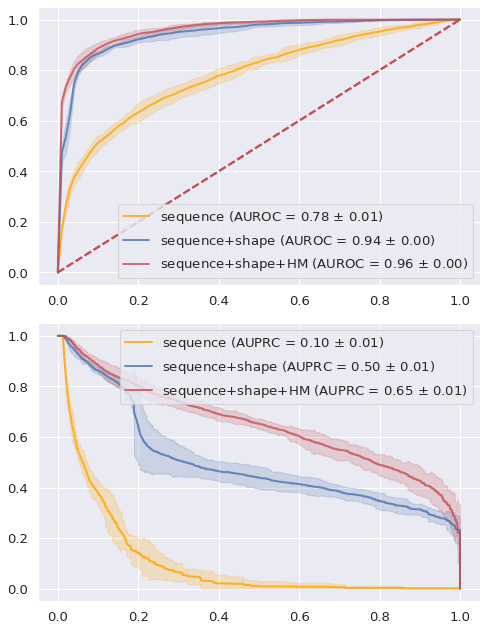

In [111]:
sns.set(font_scale=1.2)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))
fig.set_size_inches(7, 9)
print('sequence')
# results for best CV
n_estimators = 100
params =  {"max_depth":3,  "learning_rate":0.1, "min_child_weight":1, "colsample_bytree": 0.89, "n_jobs" :-1,  "scale_pos_weight":223, "random_state": 40210404}
plot_roc(Kid_Seq_Data, ax1, ax2, n_estimators, params, 'orange', 'sequence')


print('sequence+shape')
# results for best CV
n_estimators = 70
params =  {"max_depth": 3, "min_child_weight": 1, 'learning_rate': 0.1080023, "subsample": 0.899811392006158, "colsample_bytree":0.9234243, 'random_state':40210404, "max_delta_step": 1, 'scale_pos_weight': 223, "n_jobs": -1 }
plot_roc(Kidney_Seq_Sha_Data, ax1, ax2, n_estimators, params, 'b', 'sequence+shape')

print('sequence+shape+histone')
# results for best CV
n_estimators = 100
params =  { "learning_rate": 0.10997897,"max_depth": 3, "min_child_weight": 1, 'subsample':0.8899811392006158, "colsample_bytree":0.9234243, 'random_state':40210404, 'scale_pos_weight': 223, "max_delta_step":0.91654334,"n_jobs": -1 }
plot_roc(KIDNEY_three_Data, ax1, ax2, n_estimators, params, 'r', 'sequence+shape+HM')



ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('KIDNEY_FINAL_PERFORMANCE_METRICS.png')
plt.show()

### CROSS TISSUE MODELING

### 4.1 Liver to Kidney cross tissue model on sequence only dataset

In [112]:
X_train = Seq_X
y_train = Seq_Y
X_test = Kid_Seq_X
y_test = Kid_Seq_Y

In [113]:
Seq_xgb1 = XGBClassifier(max_depth=3, n_estimators =100, learning_rate=0.1, min_child_weight=1,use_label_encoder=False, colsample_bytree= 0.89, n_jobs =-1,  scale_pos_weight = 51, random_state= 40210404)
Seq_xgb1.fit(X_train,y_train)

[12:08:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.89,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=40210404, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=51, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [114]:

Seq_xgb1_pred = Seq_xgb1.predict_proba(X_test)[:,1]

Text(0.5, 257.44, 'Predicted label')

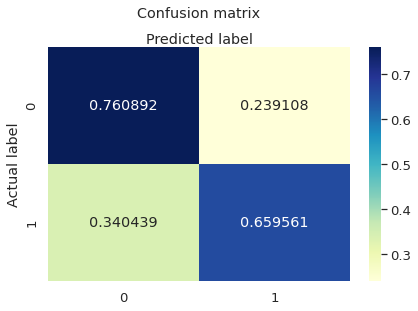

In [115]:
CM=metrics.confusion_matrix(y_test, Seq_xgb1_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('LIVER_SEQ_ONLY_XGB_Confusion_Matrix.png')

In [116]:



print(classification_report(y_test, Seq_xgb1_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    262053
           1       0.03      0.66      0.06      3237

    accuracy                           0.76    265290
   macro avg       0.51      0.71      0.46    265290
weighted avg       0.98      0.76      0.85    265290



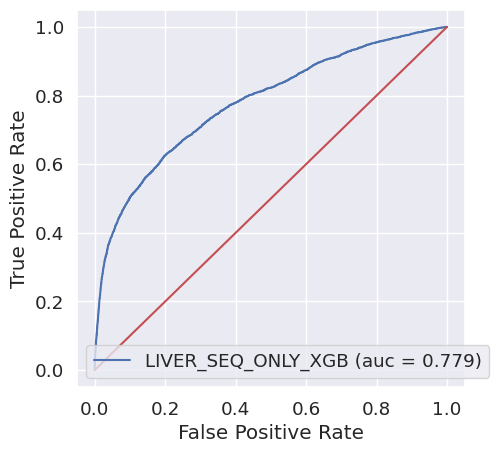

In [117]:
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test,  Seq_xgb1_pred)
auc_xgb = auc(xgb_fpr, xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, label='LIVER_SEQ_ONLY_XGB (auc = %0.3f)' % auc_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('LIVER_SEQ_ONLY_XGB_AUC.png')
plt.show()

In [118]:
liver_seq_xgb_average_precision = average_precision_score(y_test,  Seq_xgb1_pred)

print('Average precision-recliver_seq_shape score: {0:0.2f}'.format(
      liver_seq_xgb_average_precision))

Average precision-recliver_seq_shape score: 0.09


Text(0.5, 1.0, ' Precision-Recall curve: AP=0.09')

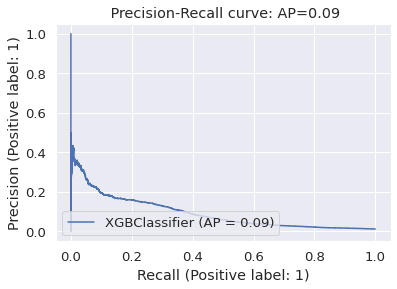

In [119]:
liver_seq_xgb_Seq = plot_precision_recall_curve( Seq_xgb1, X_test, y_test)
liver_seq_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(liver_seq_xgb_average_precision))
#plt.savefig('LIVER_SEQ_SHAPE_XGB_PR_CURVE.png')

### 4.2 Liver to Kidney cross tissue model on sequence plus DNA shape dataset

In [120]:
X_train = Liver_SEQ_SHAPE_X
y_train = Liver_SEQ_SHAPE_Y
X_test = Kidney_Seq_Sha_Data_X
y_test = Kidney_Seq_Sha_Data_Y


In [121]:
liver_seq_shape_xgb_params= {
    'learning_rate': 0.10999997,
    'max_depth': 8,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':60 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 51,
    'subsample':0.899811392006158
    
    
}

In [122]:

liver_Seq_Shape_xgb = XGBClassifier(**liver_seq_shape_xgb_params, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
liver_Seq_Shape_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.10999997, max_delta_step=0.985654334, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=51,
              subsample=0.899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

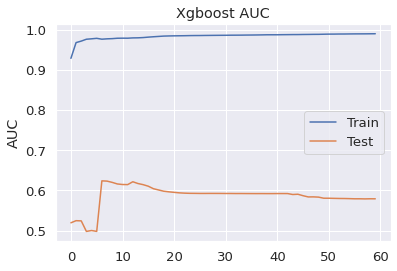

In [123]:



history = liver_Seq_Shape_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [124]:
liver_Seq_Shape_xgb_pred = liver_Seq_Shape_xgb.predict_proba(X_test)[:, 1]

Text(0.5, 257.44, 'Predicted label')

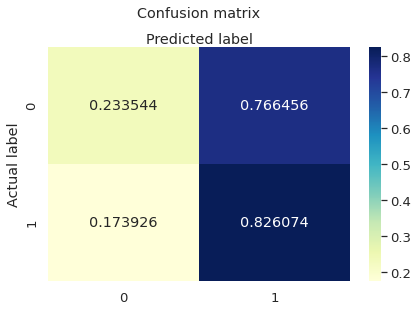

In [125]:
CM=metrics.confusion_matrix(y_test, liver_Seq_Shape_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('LIVER_SEQ_SHAPE_XGB_Confusion_Matrix.png')

In [126]:
print(classification_report(y_test, liver_Seq_Shape_xgb_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.23      0.38    262053
           1       0.01      0.83      0.03      3237

    accuracy                           0.24    265290
   macro avg       0.50      0.53      0.20    265290
weighted avg       0.98      0.24      0.37    265290



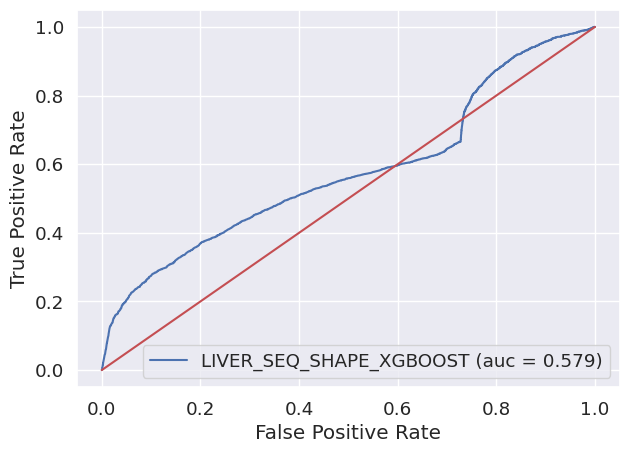

In [127]:
liver_seq_shape_xgb_fpr, liver_seq_shape_xgb_tpr, threshold = roc_curve(y_test,liver_Seq_Shape_xgb_pred)
auc_liver_seq_shape_xgb = auc(liver_seq_shape_xgb_fpr, liver_seq_shape_xgb_tpr)


plt.figure(figsize=(7, 5), dpi=100)
plt.plot(liver_seq_shape_xgb_fpr, liver_seq_shape_xgb_tpr, label='LIVER_SEQ_SHAPE_XGBOOST (auc = %0.3f)' % auc_liver_seq_shape_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('LIVER_SEQ_SHAPE_XGB_AUC_CURVE.png')
plt.show()

In [128]:
liver_seq_shape_xgb_average_precision = average_precision_score(y_test,  liver_Seq_Shape_xgb_pred)

print('Average precision-recliver_seq_shape score: {0:0.2f}'.format(
      liver_seq_shape_xgb_average_precision))

Average precision-recliver_seq_shape score: 0.03


Text(0.5, 1.0, ' Precision-Recall curve: AP=0.03')

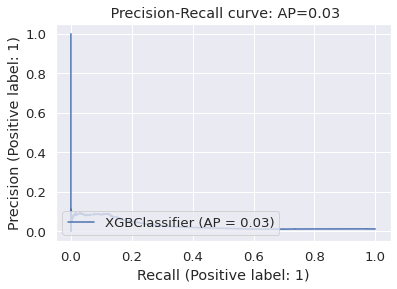

In [129]:
liver_seq_shape_xgb_Seq = plot_precision_recall_curve( liver_Seq_Shape_xgb, X_test, y_test)
liver_seq_shape_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(liver_seq_shape_xgb_average_precision))
#plt.savefig('LIVER_SEQ_SHAPE_XGB_PR_CURVE.png')

###   4.3 Liver to Kidney cross tissue model on sequence plus DNA shape plus histone modification dataset

In [130]:
X_train = LIVER_SSH_Data_X
y_train = LIVER_SSH_Data_Y
X_test = KIDNEY_three_Data_X
y_test = KIDNEY_three_Data_Y

In [131]:
Histone_xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.10999997,
    'max_depth': 8,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':60 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 51,
    'subsample':0.899811392006158
    
    
}

In [132]:

Histone_xgb = XGBClassifier(**Histone_xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
Histone_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.10999997, max_delta_step=0.985654334, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=51,
              subsample=0.899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

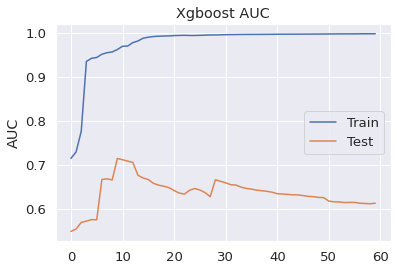

In [133]:



history = Histone_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [134]:
Histone_xgb_pred = Histone_xgb.predict_proba(X_test)[:, 1]

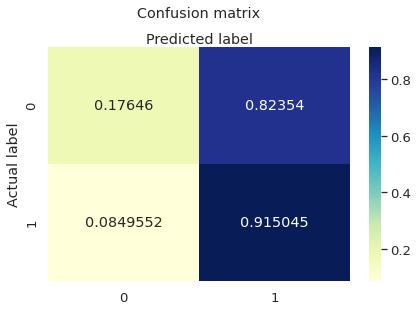

In [135]:
CM=metrics.confusion_matrix(y_test, Histone_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('LIVER_KIDNEY_CROSS_TISSUE_Confusion_Matrix.png')

In [136]:

print(classification_report(y_test, Histone_xgb_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.18      0.30    262053
           1       0.01      0.92      0.03      3237

    accuracy                           0.19    265290
   macro avg       0.50      0.55      0.16    265290
weighted avg       0.98      0.19      0.30    265290



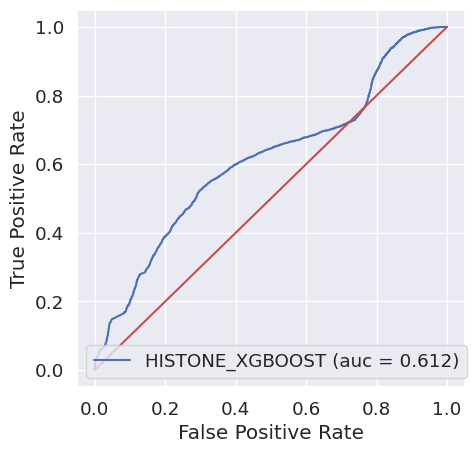

In [137]:
histone_xgb_fpr, histone_xgb_tpr, threshold = roc_curve(y_test, Histone_xgb_pred)
auc_histone_xgb = auc(histone_xgb_fpr, histone_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(histone_xgb_fpr, histone_xgb_tpr, label='HISTONE_XGBOOST (auc = %0.3f)' % auc_histone_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('LIVER_SSH_XGB_AUC_CURVE.png')
plt.show()

In [138]:
histone_xgb_average_precision = average_precision_score(y_test,  Histone_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     histone_xgb_average_precision))

Average precision-recall score: 0.02


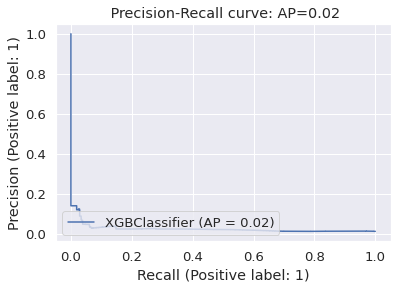

In [139]:
histone_xgb_Seq = plot_precision_recall_curve( Histone_xgb, X_test, y_test)
histone_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(histone_xgb_average_precision))
#plt.savefig('LIVER_SSH_XGB_PR_CURVE.png')
plt.show()

### 4.4 Kidney to Liver cross tissue model on sequence only dataset

In [140]:
X_train = Kid_Seq_X
y_train = Kid_Seq_Y
X_test = Seq_X
y_test = Seq_Y

In [141]:
kid_Seq_xgb1 = XGBClassifier(max_depth=3, n_estimators =100, learning_rate=0.1, min_child_weight=1, scale_pos_weight=81, use_label_encoder=False, colsample_bytree= 0.89,n_jobs =-1, random_state= 40210404)
kid_Seq_xgb1.fit(X_train,y_train)


[12:16:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.89,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=40210404, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=81, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [142]:

kid_Seq_xgb1_pred = kid_Seq_xgb1.predict_proba(X_test)[:,1]

Text(0.5, 257.44, 'Predicted label')

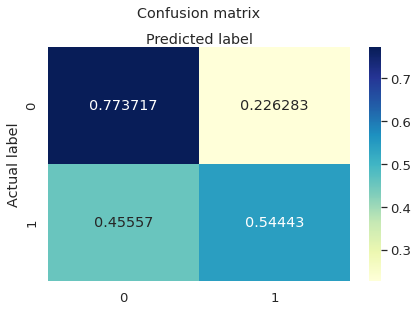

In [143]:
CM=metrics.confusion_matrix(y_test, kid_Seq_xgb1_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('KIDNEY_LIVER_CROSS_TISSUE_Confusion_Matrix.png')

In [144]:
print(classification_report(y_test, kid_Seq_xgb1_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87    189581
           1       0.05      0.54      0.08      3725

    accuracy                           0.77    193306
   macro avg       0.52      0.66      0.48    193306
weighted avg       0.97      0.77      0.85    193306



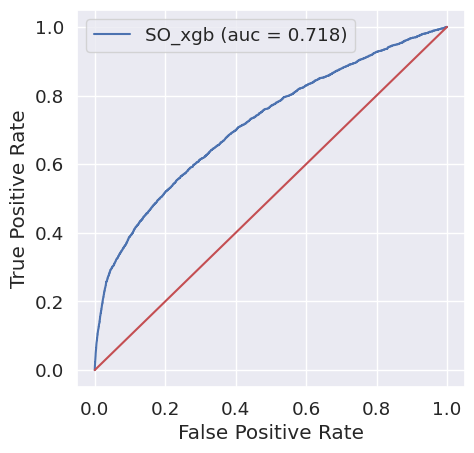

In [145]:
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test,  kid_Seq_xgb1_pred)
auc_xgb = auc(xgb_fpr, xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, label='SO_xgb (auc = %0.3f)' % auc_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('KIDNEY_SEQ_ONLY_XGB_AUC.png')
plt.show()

In [146]:
xgb_average_precision = average_precision_score(y_test,  kid_Seq_xgb1_pred)
print('Average precision-recall score: {0:0.2f}'.format(
      xgb_average_precision))

Average precision-recall score: 0.09


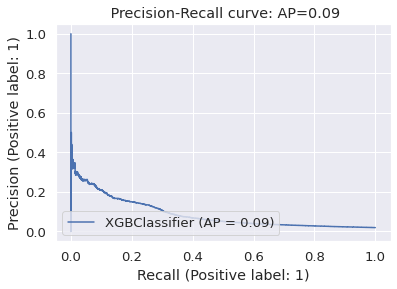

In [147]:
xgb_Seq_log = plot_precision_recall_curve(kid_Seq_xgb1, X_test, y_test)
xgb_Seq_log.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(xgb_average_precision))
#plt.savefig('KIDNEY_SEQ_ONLY_XGB_PR_CURVE.png')
plt.show()

###  4.6 Kidney to Liver cross tissue model on sequence plus DNA shape dataset

In [148]:
X_train = Kidney_Seq_Sha_Data_X
y_train = Kidney_Seq_Sha_Data_Y
X_test = Liver_SEQ_SHAPE_X
y_test = Liver_SEQ_SHAPE_Y


In [149]:
xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.100997897,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':70 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 81,
    'colsample_bylevel': 0.85797,
    'subsample':0.8899811392006158
    
    
    
}

In [150]:

kid_seq_sha_xgb = XGBClassifier(**xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
kid_seq_sha_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85797,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100997897, max_delta_step=0.985654334,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=81,
              subsample=0.8899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

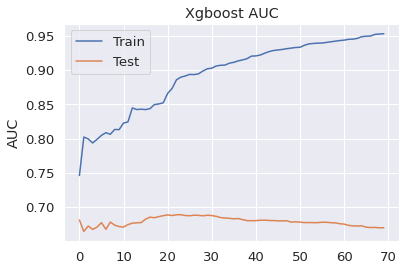

In [151]:
history = kid_seq_sha_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [152]:
kid_seq_sha_xgb_pred = kid_seq_sha_xgb.predict_proba(X_test)[:, 1]

Text(0.5, 257.44, 'Predicted label')

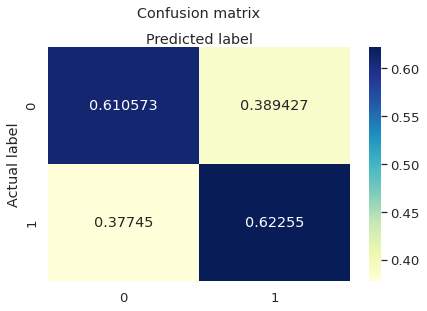

In [153]:


CM=metrics.confusion_matrix(y_test, kid_seq_sha_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('KIDNEY_SEQ_SHAPE_XGB_Confusion_Matrix.png')

In [154]:
print(classification_report(y_test, kid_seq_sha_xgb_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.61      0.75    189581
           1       0.03      0.62      0.06      3725

    accuracy                           0.61    193306
   macro avg       0.51      0.62      0.41    193306
weighted avg       0.97      0.61      0.74    193306



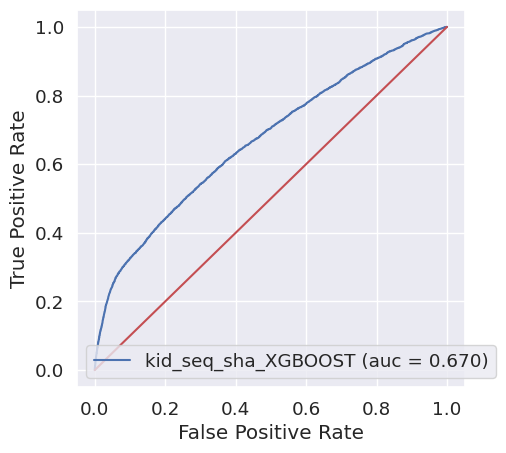

In [155]:
kid_seq_sha_xgb_fpr, kid_seq_sha_xgb_tpr, threshold = roc_curve(y_test, kid_seq_sha_xgb_pred)
auc_kid_seq_sha_xgb = auc(kid_seq_sha_xgb_fpr, kid_seq_sha_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(kid_seq_sha_xgb_fpr, kid_seq_sha_xgb_tpr, label='kid_seq_sha_XGBOOST (auc = %0.3f)' % auc_kid_seq_sha_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('KIDNEY_SEQ_SHAPE_XGB_AUC_CURVE.png')
plt.show()

In [156]:
kid_seq_sha_xgb_average_precision = average_precision_score(y_test,  kid_seq_sha_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     kid_seq_sha_xgb_average_precision))

Average precision-recall score: 0.06


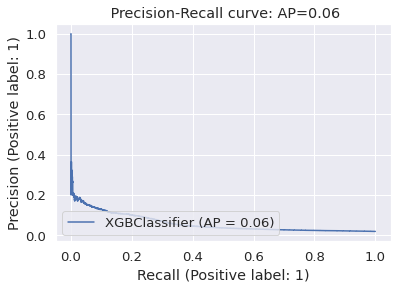

In [157]:
kid_seq_sha_xgb_Seq = plot_precision_recall_curve( kid_seq_sha_xgb, X_test, y_test)
kid_seq_sha_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(kid_seq_sha_xgb_average_precision))
#plt.savefig('KIDNEY_SEQ_SHAPE_XGB_PR_CURVE.png')
plt.show()

###   4.6 Kidney to Liver cross tissue model on sequence plus DNA shape plus histone modification dataset

In [158]:
X_train = KIDNEY_three_Data_X
y_train = KIDNEY_three_Data_Y
X_test = LIVER_SSH_Data_X
y_test = LIVER_SSH_Data_Y

In [159]:
Histone_xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.10997897,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':100 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 81,
    'colsample_bylevel': 0.85797,
    'subsample':0.8899811392006158
    
    
    
}

In [160]:

Histone_kidney_xgb = XGBClassifier(**Histone_xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
Histone_kidney_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85797,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.10997897, max_delta_step=0.985654334, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=81, subsample=0.8899811392006158,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

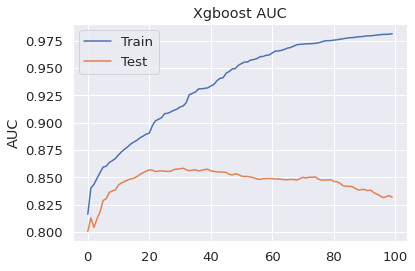

In [161]:
history = Histone_kidney_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [162]:
Histone_kidney_xgb_pred = Histone_kidney_xgb.predict_proba(X_test)[:, 1]

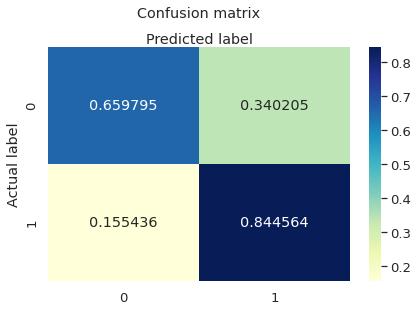

In [163]:


CM=metrics.confusion_matrix(y_test, Histone_kidney_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('KIDNEY_LIVER_CROSS_TISSUE_Confusion_Matrix.png')

In [164]:
print(classification_report(y_test, Histone_kidney_xgb_pred.round()))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79     30073
           1       0.24      0.84      0.37      3725

    accuracy                           0.68     33798
   macro avg       0.60      0.75      0.58     33798
weighted avg       0.89      0.68      0.74     33798



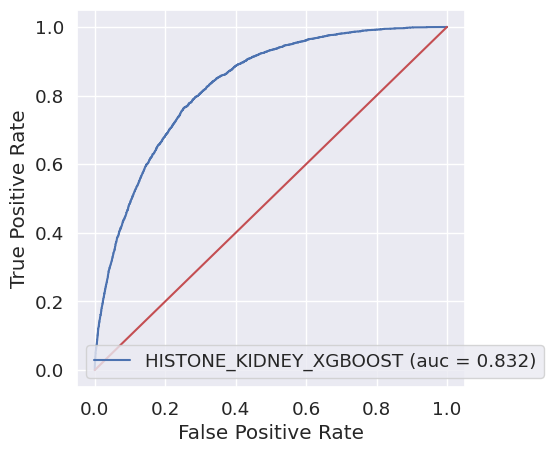

In [165]:
histone_kidney_xgb_fpr, histone_kidney_xgb_tpr, threshold = roc_curve(y_test, Histone_kidney_xgb_pred)
auc_histone_kidney_xgb = auc(histone_kidney_xgb_fpr, histone_kidney_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(histone_kidney_xgb_fpr, histone_kidney_xgb_tpr, label='HISTONE_KIDNEY_XGBOOST (auc = %0.3f)' % auc_histone_kidney_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('KIDNEY_SSH_XGB_AUC_CURVE.png')
plt.show()

In [166]:
histone_kidney_xgb_average_precision = average_precision_score(y_test,  Histone_kidney_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     histone_kidney_xgb_average_precision))

Average precision-recall score: 0.39


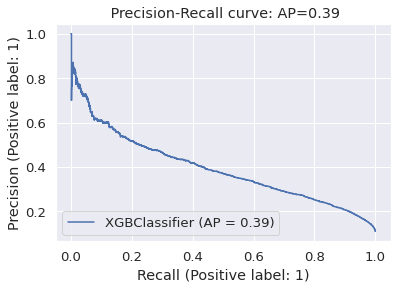

In [167]:
histone_kidney_xgb_Seq = plot_precision_recall_curve( Histone_kidney_xgb, X_test, y_test)
histone_kidney_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(histone_kidney_xgb_average_precision))
#plt.savefig('KIDNEY_SSH_XGB_PR_CURVE.png')
plt.show()

### 4.7 Liver to Heart cross tissue model on sequence only dataset

In [168]:
X_train = Seq_X
y_train = Seq_Y
X_test = heart_Seq_X 
y_test = heart_Seq_Y

In [169]:
Seq_xgb1 = XGBClassifier(max_depth=3, n_estimators =100, learning_rate=0.1, min_child_weight=1,use_label_encoder=False, colsample_bytree= 0.89, n_jobs =-1,  scale_pos_weight = 51, random_state= 40210404)
Seq_xgb1.fit(X_train,y_train)

[12:21:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.89,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=40210404, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=51, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [170]:

Seq_xgb1_pred = Seq_xgb1.predict_proba(X_test)[:,1]

Text(0.5, 257.44, 'Predicted label')

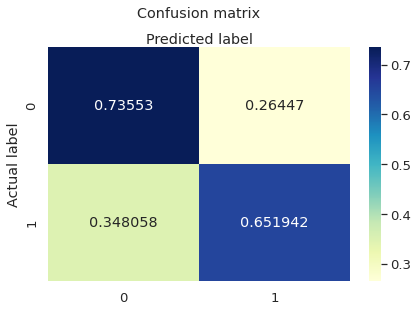

In [171]:
CM=metrics.confusion_matrix(y_test, Seq_xgb1_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('LIVER_SEQ_ONLY_XGB_Confusion_Matrix.png')

In [172]:



print(classification_report(y_test, Seq_xgb1_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85    291840
           1       0.01      0.65      0.02      1313

    accuracy                           0.74    293153
   macro avg       0.50      0.69      0.43    293153
weighted avg       0.99      0.74      0.84    293153



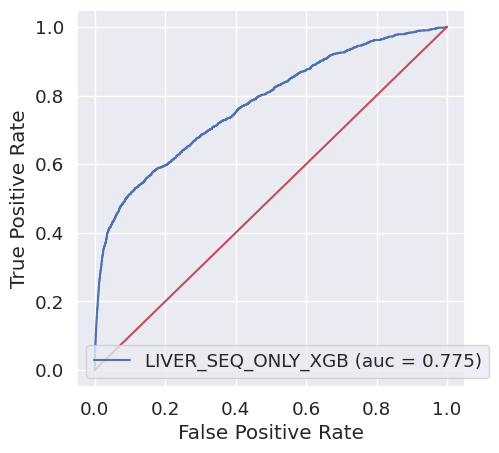

In [173]:
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test,  Seq_xgb1_pred)
auc_xgb = auc(xgb_fpr, xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, label='LIVER_SEQ_ONLY_XGB (auc = %0.3f)' % auc_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('LIVER_SEQ_ONLY_XGB_AUC.png')
plt.show()

In [174]:
liver_seq_xgb_average_precision = average_precision_score(y_test,  Seq_xgb1_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     liver_seq_xgb_average_precision))

Average precision-recall score: 0.05


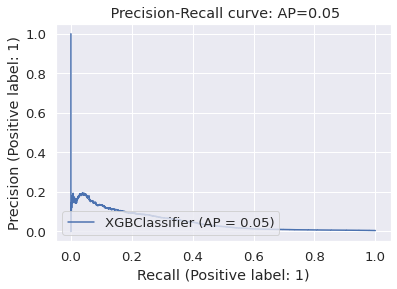

In [175]:
liver_seq_xgb_Seq = plot_precision_recall_curve( Seq_xgb1, X_test, y_test)
liver_seq_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format( liver_seq_xgb_average_precision))
#plt.savefig('KIDNEY_SEQ_SHAPE_XGB_PR_CURVE.png')
plt.show()

### 4.8 Liver to Heart cross tissue model on sequence plus DNA shape dataset

In [176]:
X_train = Liver_SEQ_SHAPE_X
y_train = Liver_SEQ_SHAPE_Y
X_test = heart_Seq_Sha_Data_X
y_test = heart_Seq_Sha_Data_Y


In [177]:
liver_seq_shape_xgb_params= {
    'learning_rate': 0.10999997,
    'max_depth': 8,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':60 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 51,
    'subsample':0.899811392006158
    
    
}

In [178]:

liver_Seq_Shape_xgb = XGBClassifier(**liver_seq_shape_xgb_params, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
liver_Seq_Shape_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.10999997, max_delta_step=0.985654334, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=51,
              subsample=0.899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

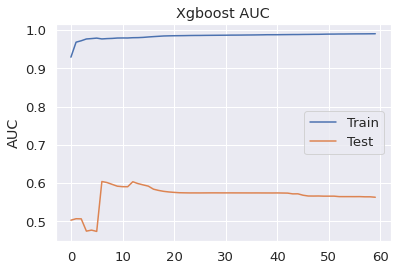

In [179]:



history = liver_Seq_Shape_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [180]:
liver_Seq_Shape_xgb_pred = liver_Seq_Shape_xgb.predict_proba(X_test)[:, 1]

Text(0.5, 257.44, 'Predicted label')

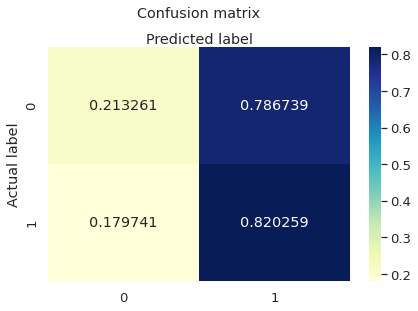

In [181]:
CM=metrics.confusion_matrix(y_test, liver_Seq_Shape_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('LIVER_SEQ_SHAPE_XGB_Confusion_Matrix.png')

In [182]:
print(classification_report(y_test, liver_Seq_Shape_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.21      0.35    291840
           1       0.00      0.82      0.01      1313

    accuracy                           0.22    293153
   macro avg       0.50      0.52      0.18    293153
weighted avg       0.99      0.22      0.35    293153



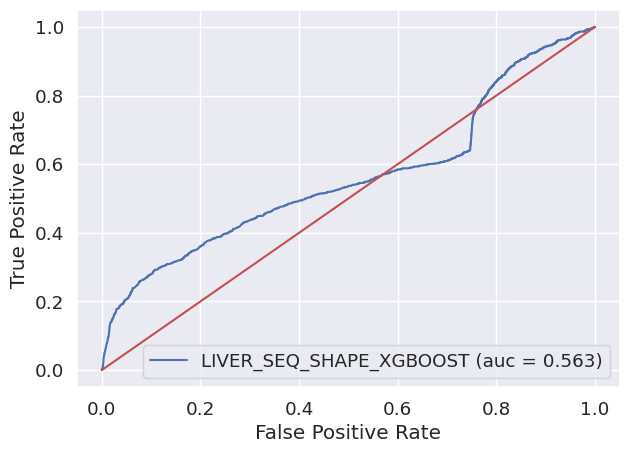

In [183]:
liver_seq_shape_xgb_fpr, liver_seq_shape_xgb_tpr, threshold = roc_curve(y_test,liver_Seq_Shape_xgb_pred)
auc_liver_seq_shape_xgb = auc(liver_seq_shape_xgb_fpr, liver_seq_shape_xgb_tpr)


plt.figure(figsize=(7, 5), dpi=100)
plt.plot(liver_seq_shape_xgb_fpr, liver_seq_shape_xgb_tpr, label='LIVER_SEQ_SHAPE_XGBOOST (auc = %0.3f)' % auc_liver_seq_shape_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('LIVER_SEQ_SHAPE_XGB_AUC_CURVE.png')
plt.show()

In [184]:
liver_seq_shape_xgb_average_precision = average_precision_score(y_test,  liver_Seq_Shape_xgb_pred)

print('Average precision-recliver_seq_shape score: {0:0.2f}'.format(
      liver_seq_shape_xgb_average_precision))

Average precision-recliver_seq_shape score: 0.01


Text(0.5, 1.0, ' Precision-Recall curve: AP=0.01')

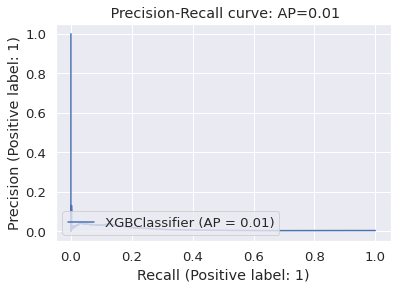

In [185]:
liver_seq_shape_xgb_Seq = plot_precision_recall_curve( liver_Seq_Shape_xgb, X_test, y_test)
liver_seq_shape_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(liver_seq_shape_xgb_average_precision))
#plt.savefig('LIVER_SEQ_SHAPE_XGB_PR_CURVE.png')

### 4.9 Liver to Heart cross tissue model on sequence plus shape plus histone modification dataset

In [186]:
X_train = LIVER_SSH_Data_X
y_train = LIVER_SSH_Data_Y
X_test = HEART_three_Data_X
y_test = HEART_three_Data_Y

In [187]:
Histone_xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.10999997,
    'max_depth': 8,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':60 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 51,
    'subsample':0.899811392006158
    
    
}

In [188]:

Histone_xgb = XGBClassifier(**Histone_xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
Histone_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.10999997, max_delta_step=0.985654334, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=51,
              subsample=0.899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

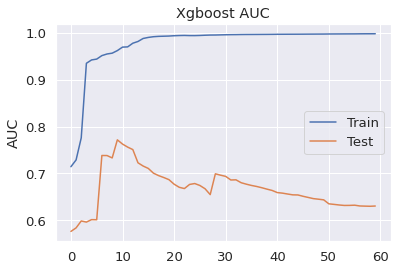

In [189]:



history = Histone_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [190]:
Histone_xgb_pred = Histone_xgb.predict_proba(X_test)[:, 1]

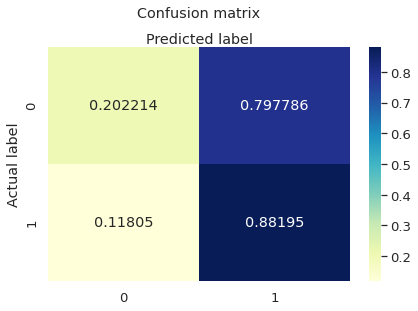

In [191]:
CM=metrics.confusion_matrix(y_test, Histone_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('LIVER_HEART_CROSS_TISSUE_Confusion_Matrix.png')

In [192]:

print(classification_report(y_test, Histone_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.20      0.34    291840
           1       0.00      0.88      0.01      1313

    accuracy                           0.21    293153
   macro avg       0.50      0.54      0.17    293153
weighted avg       0.99      0.21      0.33    293153



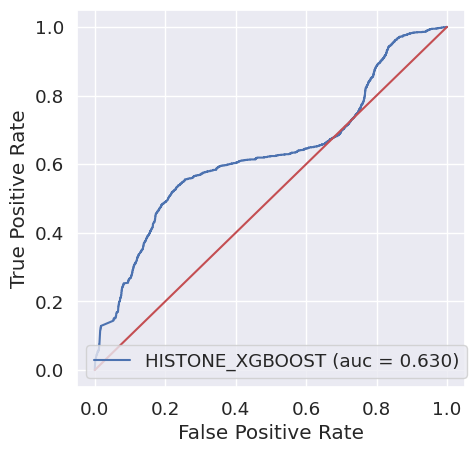

In [193]:
histone_xgb_fpr, histone_xgb_tpr, threshold = roc_curve(y_test, Histone_xgb_pred)
auc_histone_xgb = auc(histone_xgb_fpr, histone_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(histone_xgb_fpr, histone_xgb_tpr, label='HISTONE_XGBOOST (auc = %0.3f)' % auc_histone_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('LIVER_SSH_XGB_AUC_CURVE.png')
plt.show()

In [194]:
histone_xgb_average_precision = average_precision_score(y_test,  Histone_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     histone_xgb_average_precision))

Average precision-recall score: 0.01


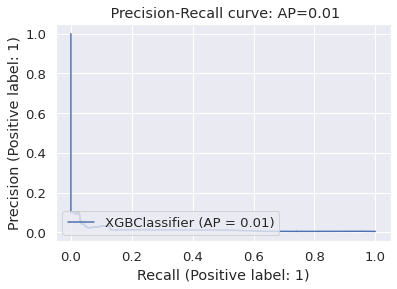

In [195]:
histone_xgb_Seq = plot_precision_recall_curve( Histone_xgb, X_test, y_test)
histone_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(histone_xgb_average_precision))
#plt.savefig('LIVER_SSH_XGB_PR_CURVE.png')
plt.show()

### 4.10 Heart to Liver cross tissue model on sequence only dataset

In [196]:
X_train = heart_Seq_X
y_train = heart_Seq_Y
X_test = Seq_X 
y_test = Seq_Y

In [197]:
heart_Seq_xgb1 = XGBClassifier(max_depth=3, n_estimators =100, learning_rate=0.1, min_child_weight=1,use_label_encoder=False, colsample_bytree= 0.89,n_jobs =-1,  scale_pos_weight = 223, random_state= 40210404)
heart_Seq_xgb1.fit(X_train,y_train)

[12:24:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.89,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=40210404, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=223, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [198]:

heart_Seq_xgb1_pred = heart_Seq_xgb1.predict_proba(X_test)[:,1]

Text(0.5, 257.44, 'Predicted label')

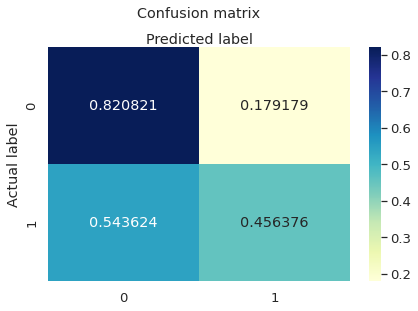

In [199]:
CM=metrics.confusion_matrix(y_test, heart_Seq_xgb1_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('HEART_SEQ_ONLY_XGB_Confusion_Matrix.png')

In [200]:



print(classification_report(y_test, heart_Seq_xgb1_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90    189581
           1       0.05      0.46      0.09      3725

    accuracy                           0.81    193306
   macro avg       0.52      0.64      0.49    193306
weighted avg       0.97      0.81      0.88    193306



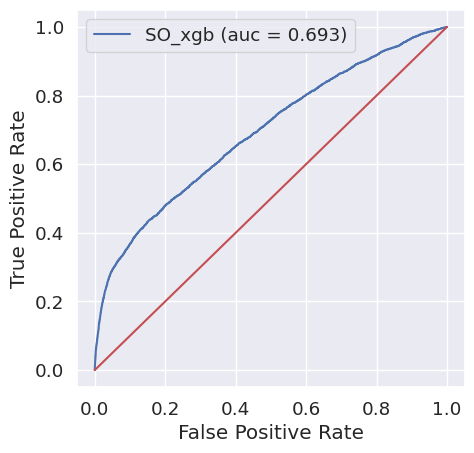

In [201]:
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test,  heart_Seq_xgb1_pred)
auc_xgb = auc(xgb_fpr, xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, label='SO_xgb (auc = %0.3f)' % auc_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('HEART_SEQ_ONLY_XGB_AUC.png')
plt.show()

In [202]:
xgb_average_precision = average_precision_score(y_test,  heart_Seq_xgb1_pred)
print('Average precision-recall score: {0:0.2f}'.format(
      xgb_average_precision))

Average precision-recall score: 0.08


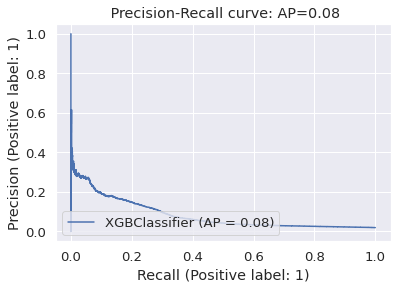

In [203]:
xgb_Seq_log = plot_precision_recall_curve(heart_Seq_xgb1, X_test, y_test)
xgb_Seq_log.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(xgb_average_precision))
#plt.savefig('HEART_SEQ_ONLY_XGB_PR_CURVE.png')
plt.show()

### 4.11 Heart to Liver cross tissue model on sequence plus DNA shape dataset

In [204]:
X_train = heart_Seq_Sha_Data_X
y_train = heart_Seq_Sha_Data_Y
X_test = Liver_SEQ_SHAPE_X
y_test = Liver_SEQ_SHAPE_Y


In [205]:
 xgb_params_fixed = {
     'learning_rate': 0.1080023,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':70 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 223,
    'subsample':0.899811392006158
    
    
    
}

In [206]:

heart_seq_sha_xgb = XGBClassifier(**xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
heart_seq_sha_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1080023, max_delta_step=0.985654334, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=70, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=223,
              subsample=0.899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

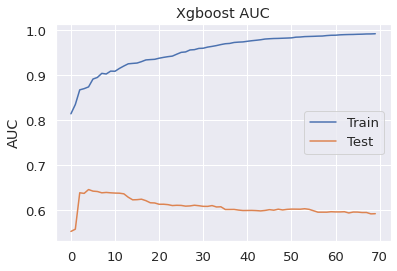

In [207]:
history = heart_seq_sha_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [208]:
heart_seq_sha_xgb_pred = heart_seq_sha_xgb.predict_proba(X_test)[:, 1]

Text(0.5, 257.44, 'Predicted label')

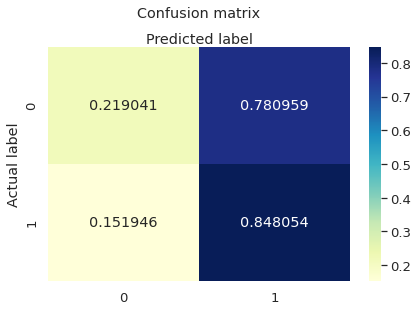

In [209]:


CM=metrics.confusion_matrix(y_test, heart_seq_sha_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('HEART_SEQ_SHAPE_XGB_Confusion_Matrix.png')

In [210]:
print(classification_report(y_test, heart_seq_sha_xgb_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.22      0.36    189581
           1       0.02      0.85      0.04      3725

    accuracy                           0.23    193306
   macro avg       0.50      0.53      0.20    193306
weighted avg       0.97      0.23      0.35    193306



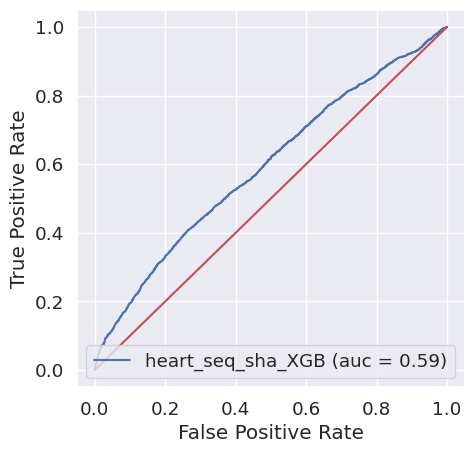

In [211]:
heart_seq_sha_xgb_fpr, heart_seq_sha_xgb_tpr, threshold = roc_curve(y_test, heart_seq_sha_xgb_pred)
auc_heart_seq_sha_xgb = auc(heart_seq_sha_xgb_fpr, heart_seq_sha_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(heart_seq_sha_xgb_fpr, heart_seq_sha_xgb_tpr, label='heart_seq_sha_XGB (auc = %0.2f)' % auc_heart_seq_sha_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('HEART_SEQ_SHAPE_XGB_AUC_CURVE.png')
plt.show()

In [212]:
heart_seq_sha_xgb_average_precision = average_precision_score(y_test,  heart_seq_sha_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     heart_seq_sha_xgb_average_precision))

Average precision-recall score: 0.03


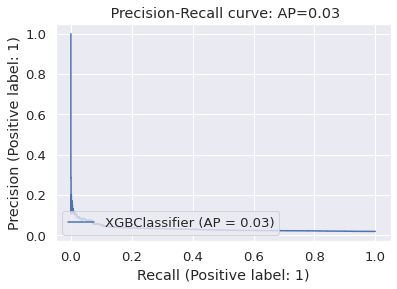

In [213]:
heart_seq_sha_xgb_Seq = plot_precision_recall_curve( heart_seq_sha_xgb, X_test, y_test)
heart_seq_sha_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(heart_seq_sha_xgb_average_precision))
#plt.savefig('HEART_SEQ_SHAPE_XGB_PR_CURVE.png')
plt.show()

### 4.12 Heart to Liver cross tissue model on sequence plus DNA shape plus histone modification dataset

In [214]:
X_train = HEART_three_Data_X
y_train = HEART_three_Data_Y
X_test = LIVER_SSH_Data_X
y_test = LIVER_SSH_Data_Y

In [215]:
Histone_xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.2997897,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':40 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 223,
    'colsample_bylevel': 0.85797,
    'random_state': 40210404,
    'subsample':0.8899811392006158
    
    
    
}

In [216]:

Histone_heart_xgb = XGBClassifier(**Histone_xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
Histone_heart_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85797,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2997897, max_delta_step=0.985654334, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=40210404, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=223, subsample=0.8899811392006158,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

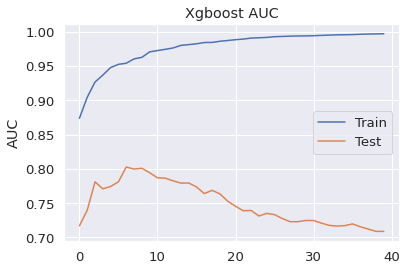

In [217]:
history = Histone_heart_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [218]:
Histone_heart_xgb_pred = Histone_heart_xgb.predict_proba(X_test)[:, 1]

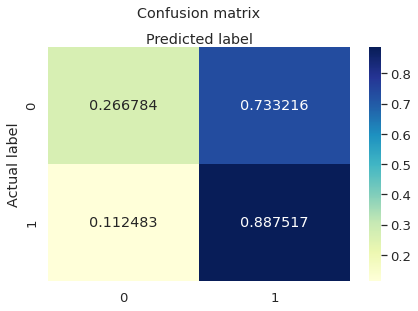

In [219]:
CM=metrics.confusion_matrix(y_test, Histone_heart_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('HEART_LIVER_CROSS_TISSUE_Confusion_Matrix.png')

In [220]:
print(classification_report(y_test, Histone_heart_xgb_pred.round()))

              precision    recall  f1-score   support

           0       0.95      0.27      0.42     30073
           1       0.13      0.89      0.23      3725

    accuracy                           0.34     33798
   macro avg       0.54      0.58      0.32     33798
weighted avg       0.86      0.34      0.40     33798



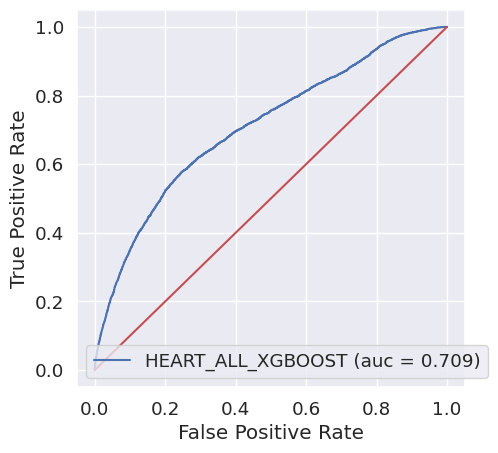

In [221]:
histone_heart_xgb_fpr, histone_heart_xgb_tpr, threshold = roc_curve(y_test, Histone_heart_xgb_pred)
auc_histone_heart_xgb = auc(histone_heart_xgb_fpr, histone_heart_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(histone_heart_xgb_fpr, histone_heart_xgb_tpr, label='HEART_ALL_XGBOOST (auc = %0.3f)' % auc_histone_heart_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('HEART_SSH_XGB_AUC_CURVE.png')
plt.show()

In [222]:
histone_heart_xgb_average_precision = average_precision_score(y_test,  Histone_heart_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     histone_heart_xgb_average_precision))

Average precision-recall score: 0.27


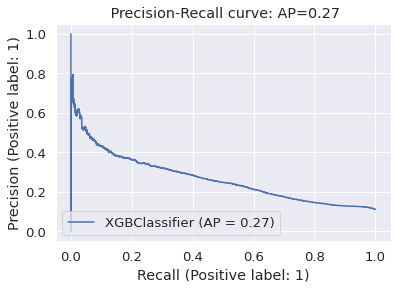

In [223]:
histone_heart_xgb_Seq = plot_precision_recall_curve( Histone_heart_xgb, X_test, y_test)
histone_heart_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(histone_heart_xgb_average_precision ))
#plt.savefig('HEART_SSH_XGB_PR_CURVE.png')
plt.show()

### 4.13 Heart to Kidney cross tissue model on sequence only dataset

In [224]:
X_train = heart_Seq_X
y_train = heart_Seq_Y
X_test = Kid_Seq_X 
y_test = Kid_Seq_Y

In [225]:
heart_Seq_xgb1 = XGBClassifier(max_depth=3, n_estimators =100, learning_rate=0.1, min_child_weight=1,use_label_encoder=False, colsample_bytree= 0.89,n_jobs =-1,  scale_pos_weight = 223, random_state= 40210404)
heart_Seq_xgb1.fit(X_train,y_train)

[12:26:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.89,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=40210404, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=223, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [226]:

heart_Seq_xgb1_pred = heart_Seq_xgb1.predict_proba(X_test)[:,1]

Text(0.5, 257.44, 'Predicted label')

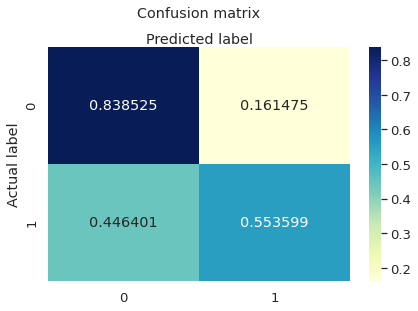

In [227]:
CM=metrics.confusion_matrix(y_test, heart_Seq_xgb1_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('HEART_SEQ_ONLY_XGB_Confusion_Matrix.png')

In [228]:



print(classification_report(y_test, heart_Seq_xgb1_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    262053
           1       0.04      0.55      0.08      3237

    accuracy                           0.84    265290
   macro avg       0.52      0.70      0.49    265290
weighted avg       0.98      0.84      0.90    265290



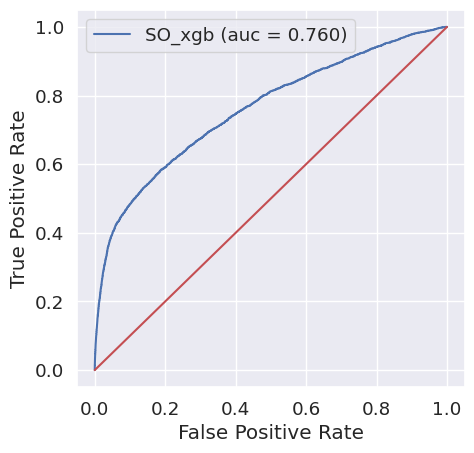

In [229]:
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test,  heart_Seq_xgb1_pred)
auc_xgb = auc(xgb_fpr, xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, label='SO_xgb (auc = %0.3f)' % auc_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('HEART_SEQ_ONLY_XGB_AUC.png')
plt.show()

In [230]:
xgb_average_precision = average_precision_score(y_test,  heart_Seq_xgb1_pred)
print('Average precision-recall score: {0:0.2f}'.format(
      xgb_average_precision))

Average precision-recall score: 0.10


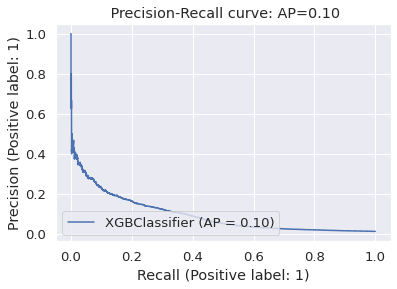

In [231]:
xgb_Seq_log = plot_precision_recall_curve(heart_Seq_xgb1, X_test, y_test)
xgb_Seq_log.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(xgb_average_precision))
#plt.savefig('HEART_SEQ_ONLY_XGB_PR_CURVE.png')
plt.show()

### 4.14 Heart to Kidney cross tissue model on sequence plus DNA shape dataset

In [232]:
X_train = heart_Seq_Sha_Data_X
y_train = heart_Seq_Sha_Data_Y
X_test = Kidney_Seq_Sha_Data_X
y_test = Kidney_Seq_Sha_Data_Y


In [233]:
 xgb_params_fixed = {
     'learning_rate': 0.1080023,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':70 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 223,
    'subsample':0.899811392006158
    
    
    
}

In [234]:

heart_seq_sha_xgb = XGBClassifier(**xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
heart_seq_sha_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1080023, max_delta_step=0.985654334, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=70, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=223,
              subsample=0.899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

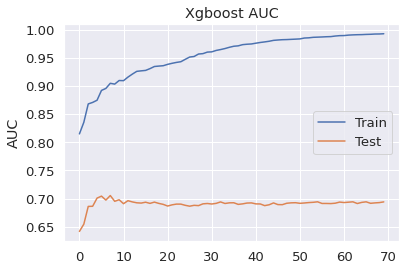

In [235]:
history = heart_seq_sha_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [236]:
heart_seq_sha_xgb_pred = heart_seq_sha_xgb.predict_proba(X_test)[:, 1]

Text(0.5, 257.44, 'Predicted label')

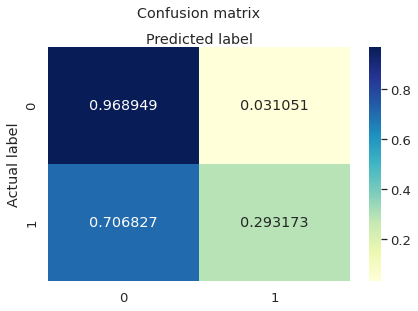

In [237]:


CM=metrics.confusion_matrix(y_test, heart_seq_sha_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('HEART_SEQ_SHAPE_XGB_Confusion_Matrix.png')

In [238]:
print(classification_report(y_test, heart_seq_sha_xgb_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    262053
           1       0.10      0.29      0.15      3237

    accuracy                           0.96    265290
   macro avg       0.55      0.63      0.57    265290
weighted avg       0.98      0.96      0.97    265290



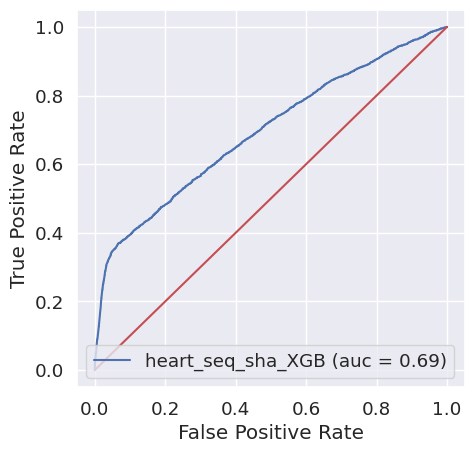

In [239]:
heart_seq_sha_xgb_fpr, heart_seq_sha_xgb_tpr, threshold = roc_curve(y_test, heart_seq_sha_xgb_pred)
auc_heart_seq_sha_xgb = auc(heart_seq_sha_xgb_fpr, heart_seq_sha_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(heart_seq_sha_xgb_fpr, heart_seq_sha_xgb_tpr, label='heart_seq_sha_XGB (auc = %0.2f)' % auc_heart_seq_sha_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('HEART_SEQ_SHAPE_XGB_AUC_CURVE.png')
plt.show()

In [240]:
heart_seq_sha_xgb_average_precision = average_precision_score(y_test,  heart_seq_sha_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     heart_seq_sha_xgb_average_precision))

Average precision-recall score: 0.06


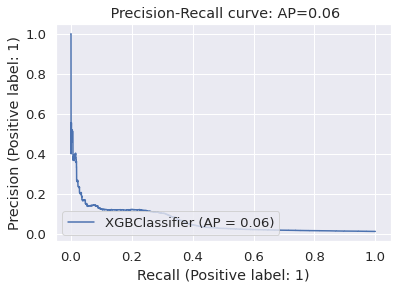

In [241]:
heart_seq_sha_xgb_Seq = plot_precision_recall_curve( heart_seq_sha_xgb, X_test, y_test)
heart_seq_sha_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(heart_seq_sha_xgb_average_precision))
#plt.savefig('HEART_SEQ_SHAPE_XGB_PR_CURVE.png')
plt.show()

### 4.15 Heart to Kidney cross tissue model on sequence plus DNA shape plus histone modification dataset

In [242]:
X_train = HEART_three_Data_X
y_train = HEART_three_Data_Y
X_test = KIDNEY_three_Data_X
y_test = KIDNEY_three_Data_Y

In [243]:
Histone_xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.2997897,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':40 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 223,
    'colsample_bylevel': 0.85797,
    'random_state': 40210404,
    'subsample':0.8899811392006158
    
    
    
}

In [244]:

Histone_heart_xgb = XGBClassifier(**Histone_xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
Histone_heart_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85797,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2997897, max_delta_step=0.985654334, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=40210404, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=223, subsample=0.8899811392006158,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

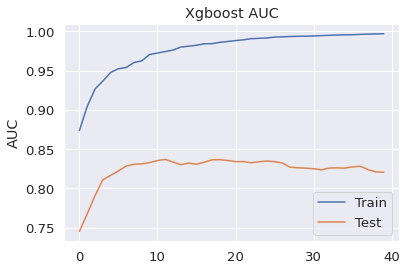

In [245]:
history = Histone_heart_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [246]:
Histone_heart_xgb_pred = Histone_heart_xgb.predict_proba(X_test)[:, 1]

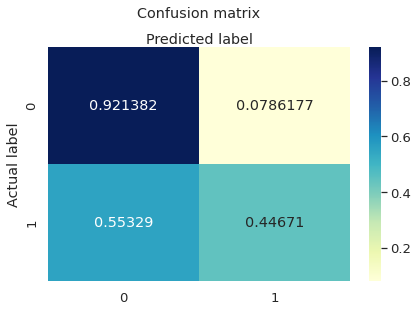

In [247]:
CM=metrics.confusion_matrix(y_test, Histone_heart_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('HEART_KIDNEY_CROSS_TISSUE_Confusion_Matrix.png')

In [248]:
print(classification_report(y_test, Histone_heart_xgb_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96    262053
           1       0.07      0.45      0.11      3237

    accuracy                           0.92    265290
   macro avg       0.53      0.68      0.54    265290
weighted avg       0.98      0.92      0.95    265290



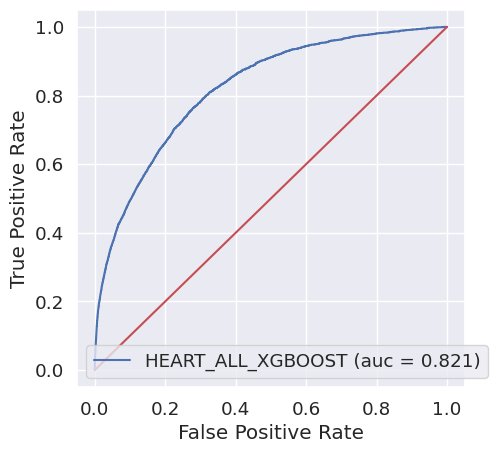

In [249]:
histone_heart_xgb_fpr, histone_heart_xgb_tpr, threshold = roc_curve(y_test, Histone_heart_xgb_pred)
auc_histone_heart_xgb = auc(histone_heart_xgb_fpr, histone_heart_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(histone_heart_xgb_fpr, histone_heart_xgb_tpr, label='HEART_ALL_XGBOOST (auc = %0.3f)' % auc_histone_heart_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('HEART_SSH_XGB_AUC_CURVE.png')
plt.show()

In [250]:
histone_heart_xgb_average_precision = average_precision_score(y_test,  Histone_heart_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     histone_heart_xgb_average_precision))

Average precision-recall score: 0.10


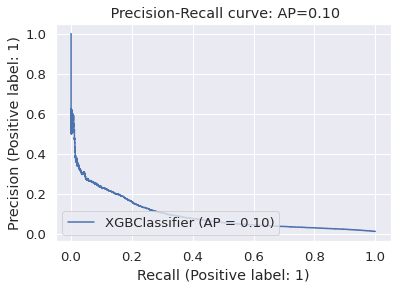

In [251]:
histone_heart_xgb_Seq = plot_precision_recall_curve( Histone_heart_xgb, X_test, y_test)
histone_heart_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(histone_heart_xgb_average_precision ))
#plt.savefig('HEART_SSH_XGB_PR_CURVE.png')
plt.show()

### 4.16 Kidney to Heart cross tissue model on sequence only dataset

In [252]:
X_train = Kid_Seq_X
y_train = Kid_Seq_Y
X_test = heart_Seq_X
y_test = heart_Seq_Y

In [253]:
kid_Seq_xgb1 = XGBClassifier(max_depth=3, n_estimators =100, learning_rate=0.1, min_child_weight=1, scale_pos_weight=81, use_label_encoder=False, colsample_bytree= 0.89,n_jobs =-1, random_state= 40210404)
kid_Seq_xgb1.fit(X_train,y_train)


[12:29:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.89,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=40210404, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=81, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [254]:

kid_Seq_xgb1_pred = kid_Seq_xgb1.predict_proba(X_test)[:,1]

Text(0.5, 257.44, 'Predicted label')

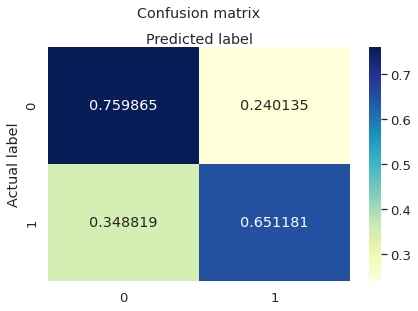

In [255]:
CM=metrics.confusion_matrix(y_test, kid_Seq_xgb1_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('KIDNEY_SEQ_ONLY_XGB_Confusion_Matrix.png')

In [256]:
print(classification_report(y_test, kid_Seq_xgb1_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    291840
           1       0.01      0.65      0.02      1313

    accuracy                           0.76    293153
   macro avg       0.50      0.71      0.44    293153
weighted avg       0.99      0.76      0.86    293153



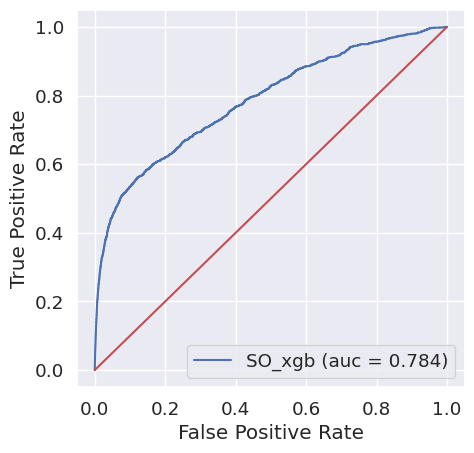

In [257]:
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test,  kid_Seq_xgb1_pred)
auc_xgb = auc(xgb_fpr, xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(xgb_fpr, xgb_tpr, label='SO_xgb (auc = %0.3f)' % auc_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('KIDNEY_SEQ_ONLY_XGB_AUC.png')
plt.show()

In [258]:
xgb_average_precision = average_precision_score(y_test,  kid_Seq_xgb1_pred)
print('Average precision-recall score: {0:0.2f}'.format(
      xgb_average_precision))

Average precision-recall score: 0.05


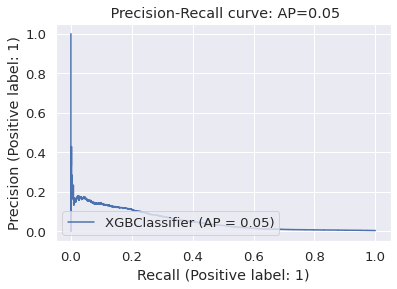

In [259]:
xgb_Seq_log = plot_precision_recall_curve(kid_Seq_xgb1, X_test, y_test)
xgb_Seq_log.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(xgb_average_precision))
#plt.savefig('KIDNEY_SEQ_ONLY_XGB_PR_CURVE.png')
plt.show()

### 4.17 Kidney to Heart cross tissue model on sequence plus DNA shape dataset

In [260]:
X_train = Kidney_Seq_Sha_Data_X
y_train = Kidney_Seq_Sha_Data_Y
X_test = heart_Seq_Sha_Data_X
y_test = heart_Seq_Sha_Data_Y


In [261]:
xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.100997897,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':70 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 81,
    'colsample_bylevel': 0.85797,
    'subsample':0.8899811392006158
    
    
    
}

In [262]:

kid_seq_sha_xgb = XGBClassifier(**xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
kid_seq_sha_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85797,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100997897, max_delta_step=0.985654334,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=81,
              subsample=0.8899811392006158, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

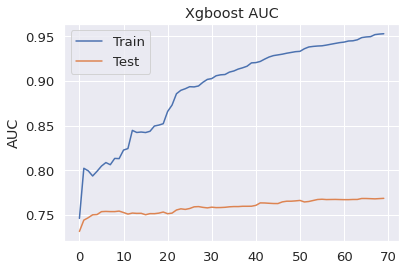

In [263]:
history = kid_seq_sha_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [264]:
kid_seq_sha_xgb_pred = kid_seq_sha_xgb.predict_proba(X_test)[:, 1]

Text(0.5, 257.44, 'Predicted label')

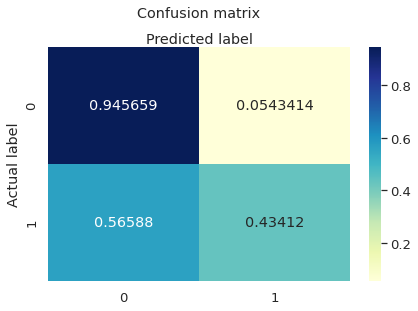

In [265]:


CM=metrics.confusion_matrix(y_test, kid_seq_sha_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('KIDNEY_SEQ_SHAPE_XGB_Confusion_Matrix.png')

In [266]:
print(classification_report(y_test, kid_seq_sha_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    291840
           1       0.03      0.43      0.06      1313

    accuracy                           0.94    293153
   macro avg       0.52      0.69      0.52    293153
weighted avg       0.99      0.94      0.97    293153



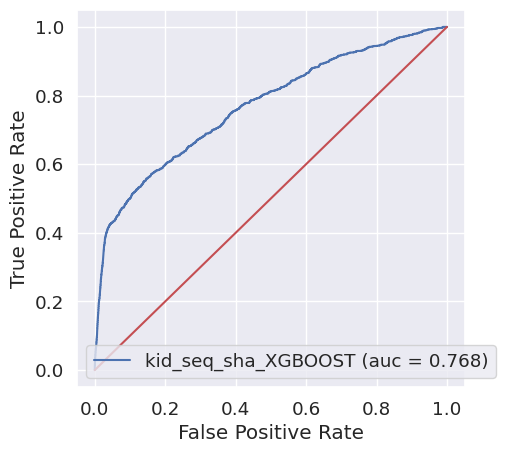

In [267]:
kid_seq_sha_xgb_fpr, kid_seq_sha_xgb_tpr, threshold = roc_curve(y_test, kid_seq_sha_xgb_pred)
auc_kid_seq_sha_xgb = auc(kid_seq_sha_xgb_fpr, kid_seq_sha_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(kid_seq_sha_xgb_fpr, kid_seq_sha_xgb_tpr, label='kid_seq_sha_XGBOOST (auc = %0.3f)' % auc_kid_seq_sha_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('KIDNEY_SEQ_SHAPE_XGB_AUC_CURVE.png')
plt.show()

In [268]:
kid_seq_sha_xgb_average_precision = average_precision_score(y_test,  kid_seq_sha_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     kid_seq_sha_xgb_average_precision))

Average precision-recall score: 0.04


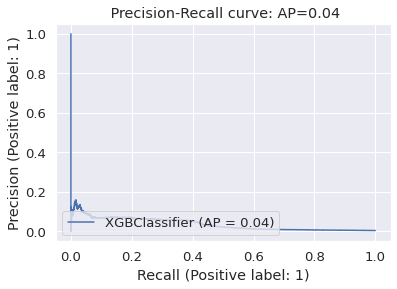

In [269]:
kid_seq_sha_xgb_Seq = plot_precision_recall_curve( kid_seq_sha_xgb, X_test, y_test)
kid_seq_sha_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(kid_seq_sha_xgb_average_precision))
#plt.savefig('KIDNEY_SEQ_SHAPE_XGB_PR_CURVE.png')
plt.show()

### 4.18 Kidney to Heart cross tissue model on sequence plus DNA shape plus histone modifications dataset

In [270]:
X_train = KIDNEY_three_Data_X
y_train = KIDNEY_three_Data_Y
X_test = HEART_three_Data_X
y_test = HEART_three_Data_Y

In [271]:
Histone_xgb_params_fixed = xgb_params_fixed = {
    'learning_rate': 0.10997897,
    'max_depth': 3,
    'colsample_bytree':0.9234243,
    'max_delta_step': 0.985654334, 
    'n_estimators':100 ,
    'n_jobs': -1,
    'min_child_weight': 1,
    'scale_pos_weight': 81,
    'colsample_bylevel': 0.85797,
    'subsample':0.8899811392006158
    
    
    
}

In [272]:

Histone_kidney_xgb = XGBClassifier(**Histone_xgb_params_fixed, use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
Histone_kidney_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85797,
              colsample_bynode=1, colsample_bytree=0.9234243,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.10997897, max_delta_step=0.985654334, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=81, subsample=0.8899811392006158,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

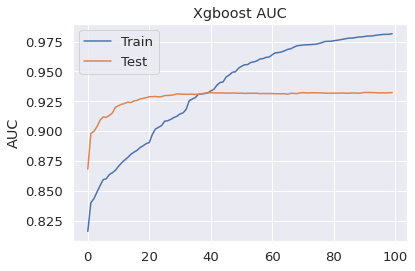

In [273]:
history = Histone_kidney_xgb.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label='Train')
plt.plot(x_axis, history['validation_1']['auc'], label='Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

In [274]:
Histone_kidney_xgb_pred = Histone_kidney_xgb.predict_proba(X_test)[:, 1]

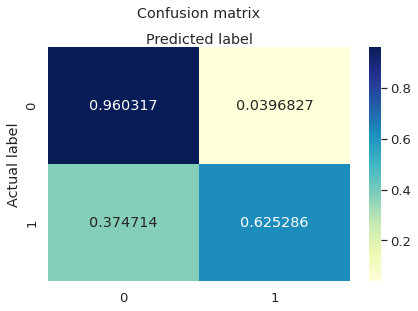

In [275]:


CM=metrics.confusion_matrix(y_test, Histone_kidney_xgb_pred.round(), normalize='true')

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(CM), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('KIDNEY_HEART_CROSS_TISSUE_Confusion_Matrix.png')

In [276]:
print(classification_report(y_test, Histone_kidney_xgb_pred.round()))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    291840
           1       0.07      0.63      0.12      1313

    accuracy                           0.96    293153
   macro avg       0.53      0.79      0.55    293153
weighted avg       0.99      0.96      0.98    293153



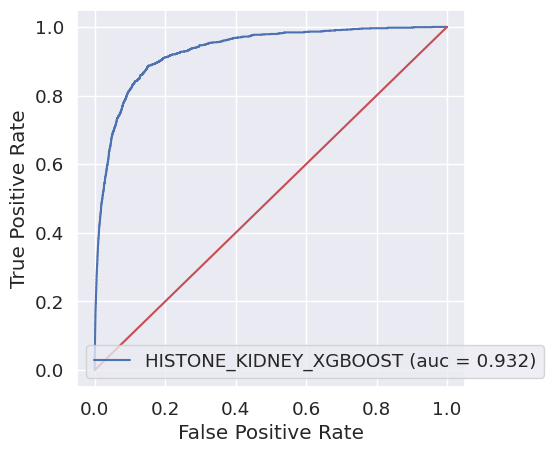

In [277]:
histone_kidney_xgb_fpr, histone_kidney_xgb_tpr, threshold = roc_curve(y_test, Histone_kidney_xgb_pred)
auc_histone_kidney_xgb = auc(histone_kidney_xgb_fpr, histone_kidney_xgb_tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(histone_kidney_xgb_fpr, histone_kidney_xgb_tpr, label='HISTONE_KIDNEY_XGBOOST (auc = %0.3f)' % auc_histone_kidney_xgb)
plt.plot([0,1], [0,1], c='r')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
#plt.savefig('KIDNEY_SSH_XGB_AUC_CURVE.png')
plt.show()

In [278]:
histone_kidney_xgb_average_precision = average_precision_score(y_test,  Histone_kidney_xgb_pred)

print('Average precision-recall score: {0:0.2f}'.format(
     histone_kidney_xgb_average_precision))

Average precision-recall score: 0.13


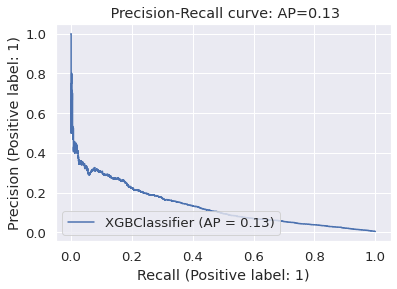

In [279]:
histone_kidney_xgb_Seq = plot_precision_recall_curve( Histone_kidney_xgb, X_test, y_test)
histone_kidney_xgb_Seq.ax_.set_title(' Precision-Recall curve: '
                   'AP={0:0.2f}'.format(histone_kidney_xgb_average_precision))
#plt.savefig('KIDNEY_SSH_XGB_PR_CURVE.png')
plt.show()

### 5 Cross tissue modeling plots

### 5.1 Cross tissue AUROC & AUPRC plots

In [4]:
#AUROC
Cross_AUROC_DATA = {'AUROC': [0.779, 0.577, 0.616, 0.718, 0.671, 0.832, 0.775, 0.55, 0.633, 0.693, 0.59, 0.731, 0.76, 0.67, 0.809,
                             0.784, 0.766,0.932], 
                    'Tissue':['liver_kidney','liver_kidney','liver_kidney', 'kidney_liver','kidney_liver','kidney_liver', 'liver_heart',
                              'liver_heart','liver_heart', 'heart_liver', 'heart_liver' , 'heart_liver','heart_kidney','heart_kidney',
                              'heart_kidney', 'kidney_heart','kidney_heart','kidney_heart'  ],
                    'Model':['Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone']}

In [5]:
Cross_AUROC_DATA  = pd.DataFrame(data = Cross_AUROC_DATA )
Cross_AUROC_DATA

AUROC        Tissue                   Model
0   0.779  liver_kidney                Sequence
1   0.577  liver_kidney          Sequence_Shape
2   0.616  liver_kidney  Sequence_Shape_Histone
3   0.718  kidney_liver                Sequence
4   0.671  kidney_liver          Sequence_Shape
5   0.832  kidney_liver  Sequence_Shape_Histone
6   0.775   liver_heart                Sequence
7   0.550   liver_heart          Sequence_Shape
8   0.633   liver_heart  Sequence_Shape_Histone
9   0.693   heart_liver                Sequence
10  0.590   heart_liver          Sequence_Shape
11  0.731   heart_liver  Sequence_Shape_Histone
12  0.760  heart_kidney                Sequence
13  0.670  heart_kidney          Sequence_Shape
14  0.809  heart_kidney  Sequence_Shape_Histone
15  0.784  kidney_heart                Sequence
16  0.766  kidney_heart          Sequence_Shape
17  0.932  kidney_heart  Sequence_Shape_Histone

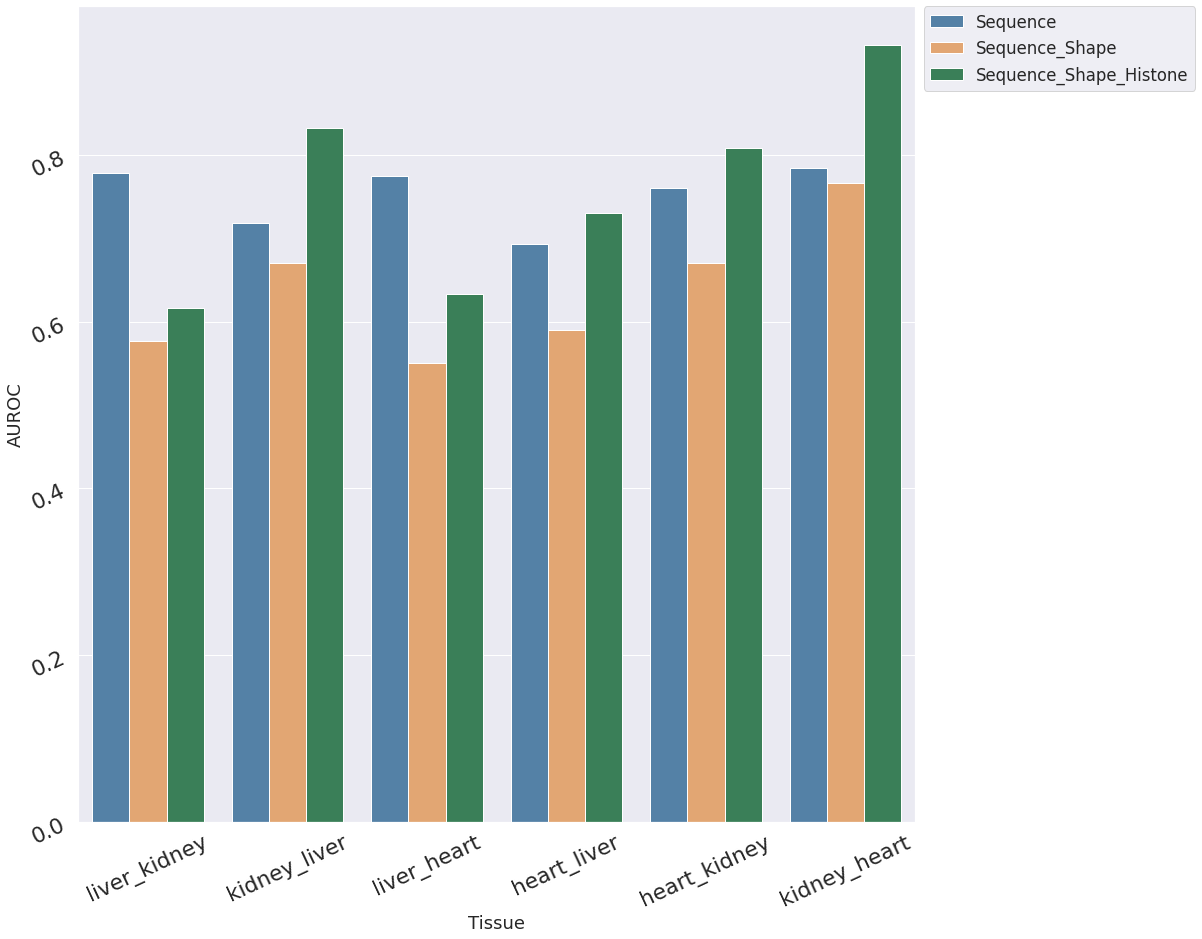

In [6]:
sns.set(font_scale = 1.5,rc={"figure.figsize":(15,15)})
#fig.set_size_inches(15, 15)
my_colors = ['steelblue', 'sandybrown', 'seagreen']
sns.set_palette( my_colors)
sns.barplot(x="Tissue", y="AUROC", hue="Model", data=Cross_AUROC_DATA  ,estimator = np.mean)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.xticks(fontsize='large',rotation = 25)
plt.yticks(fontsize='large',rotation = 25)
plt.savefig("CROSS_AUROC_PERFORMANCES.png")

In [7]:
#AUPRC
Cross_AUPRC_DATA = {'AUPRC': [0.09, 0.03, 0.03, 0.09, 0.06, 0.39, 0.05, 0.01, 0.01, 0.08, 0.04, 0.31, 0.10, 0.06, 0.08,
                             0.05, 0.04,0.12], 
                    'Tissue':['liver_kidney','liver_kidney','liver_kidney', 'kidney_liver','kidney_liver','kidney_liver', 'liver_heart',
                              'liver_heart','liver_heart', 'heart_liver', 'heart_liver' , 'heart_liver','heart_kidney','heart_kidney',
                              'heart_kidney', 'kidney_heart','kidney_heart','kidney_heart'  ],
                    'Model':['Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone']}

In [8]:
Cross_AUPRC_DATA  = pd.DataFrame(data = Cross_AUPRC_DATA )
Cross_AUPRC_DATA

AUPRC        Tissue                   Model
0    0.09  liver_kidney                Sequence
1    0.03  liver_kidney          Sequence_Shape
2    0.03  liver_kidney  Sequence_Shape_Histone
3    0.09  kidney_liver                Sequence
4    0.06  kidney_liver          Sequence_Shape
5    0.39  kidney_liver  Sequence_Shape_Histone
6    0.05   liver_heart                Sequence
7    0.01   liver_heart          Sequence_Shape
8    0.01   liver_heart  Sequence_Shape_Histone
9    0.08   heart_liver                Sequence
10   0.04   heart_liver          Sequence_Shape
11   0.31   heart_liver  Sequence_Shape_Histone
12   0.10  heart_kidney                Sequence
13   0.06  heart_kidney          Sequence_Shape
14   0.08  heart_kidney  Sequence_Shape_Histone
15   0.05  kidney_heart                Sequence
16   0.04  kidney_heart          Sequence_Shape
17   0.12  kidney_heart  Sequence_Shape_Histone

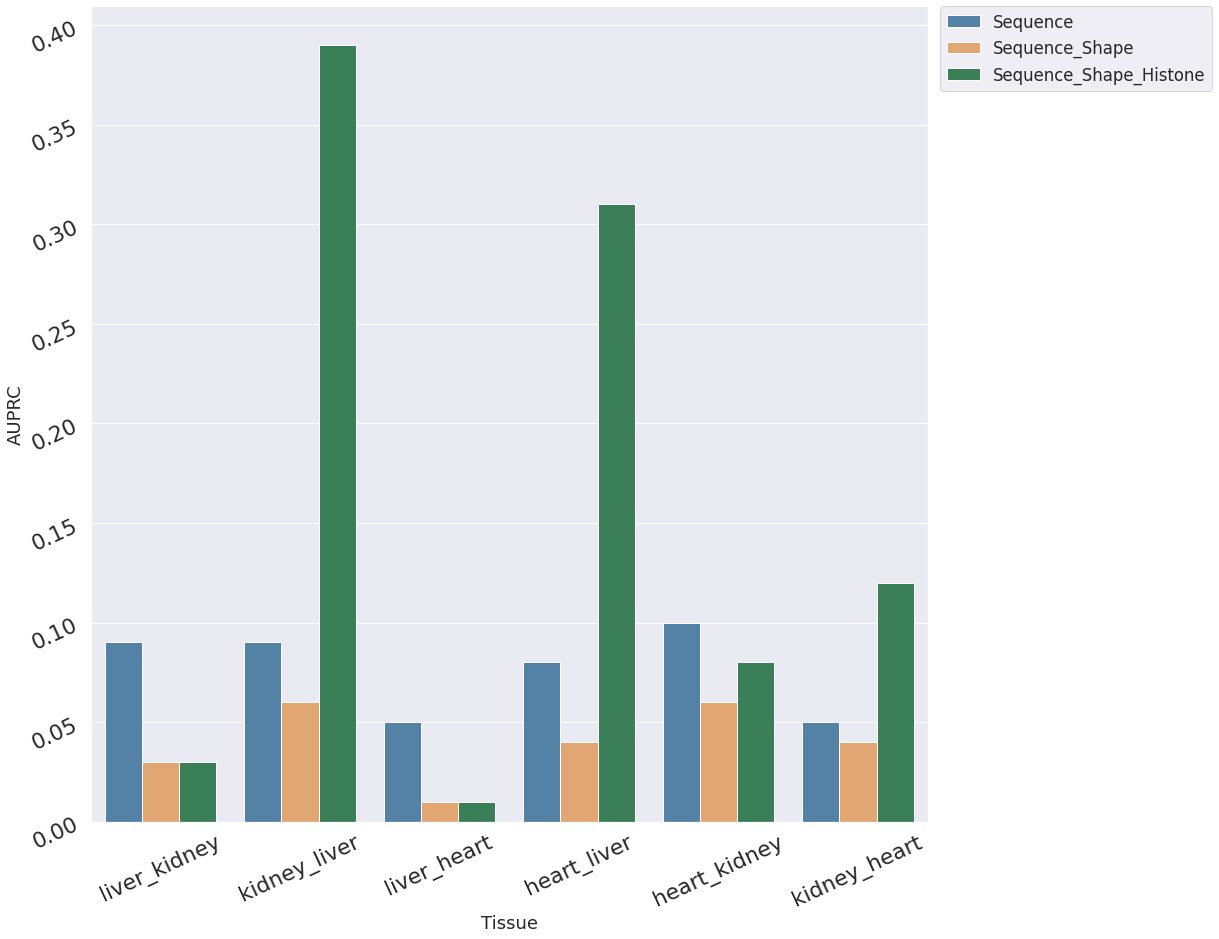

In [9]:
sns.set(font_scale = 1.5,rc={"figure.figsize":(15,15)})
#fig.set_size_inches(15, 15)
my_colors = ['steelblue', 'sandybrown', 'seagreen']
sns.set_palette( my_colors)
sns.barplot(x="Tissue", y="AUPRC", hue="Model", data=Cross_AUPRC_DATA  ,estimator = np.mean)
plt.legend(bbox_to_anchor=(1.34, 1),
           borderaxespad=0)
plt.xticks(fontsize='large',rotation = 25)
plt.yticks(fontsize='large',rotation = 25)
plt.savefig("CROSS_AUPRC_PERFORMANCES.png")

###  5.2 Cross tissue modeling True possitive and False negative plot


In [10]:
# TRUE POSITIVE
TRUE_POSITIVE_DATA = {'TRUE_POSITIVE': [0.761, 0.232, 0.17, 0.774, 0.646, 0.673, 0.74, 0.21, 0.19, 0.821, 0.209, 0.28, 0.83, 0.974, 0.915,
                             0.75, 0.950, 0.960], 
                    'Tissue':['liver_kidney','liver_kidney','liver_kidney', 'kidney_liver','kidney_liver','kidney_liver', 'liver_heart',
                              'liver_heart','liver_heart', 'heart_liver', 'heart_liver' , 'heart_liver','heart_kidney','heart_kidney',
                              'heart_kidney', 'kidney_heart','kidney_heart','kidney_heart'  ],
                    'Model':['Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone']}

In [11]:
TRUE_POSITIVE_DATA  = pd.DataFrame(data = TRUE_POSITIVE_DATA  )
TRUE_POSITIVE_DATA 

TRUE_POSITIVE        Tissue                   Model
0           0.761  liver_kidney                Sequence
1           0.232  liver_kidney          Sequence_Shape
2           0.170  liver_kidney  Sequence_Shape_Histone
3           0.774  kidney_liver                Sequence
4           0.646  kidney_liver          Sequence_Shape
5           0.673  kidney_liver  Sequence_Shape_Histone
6           0.740   liver_heart                Sequence
7           0.210   liver_heart          Sequence_Shape
8           0.190   liver_heart  Sequence_Shape_Histone
9           0.821   heart_liver                Sequence
10          0.209   heart_liver          Sequence_Shape
11          0.280   heart_liver  Sequence_Shape_Histone
12          0.830  heart_kidney                Sequence
13          0.974  heart_kidney          Sequence_Shape
14          0.915  heart_kidney  Sequence_Shape_Histone
15          0.750  kidney_heart                Sequence
16          0.950  kidney_heart          Sequence_Shape
17          0.960  kidney_heart  Sequence_Shape_Histone

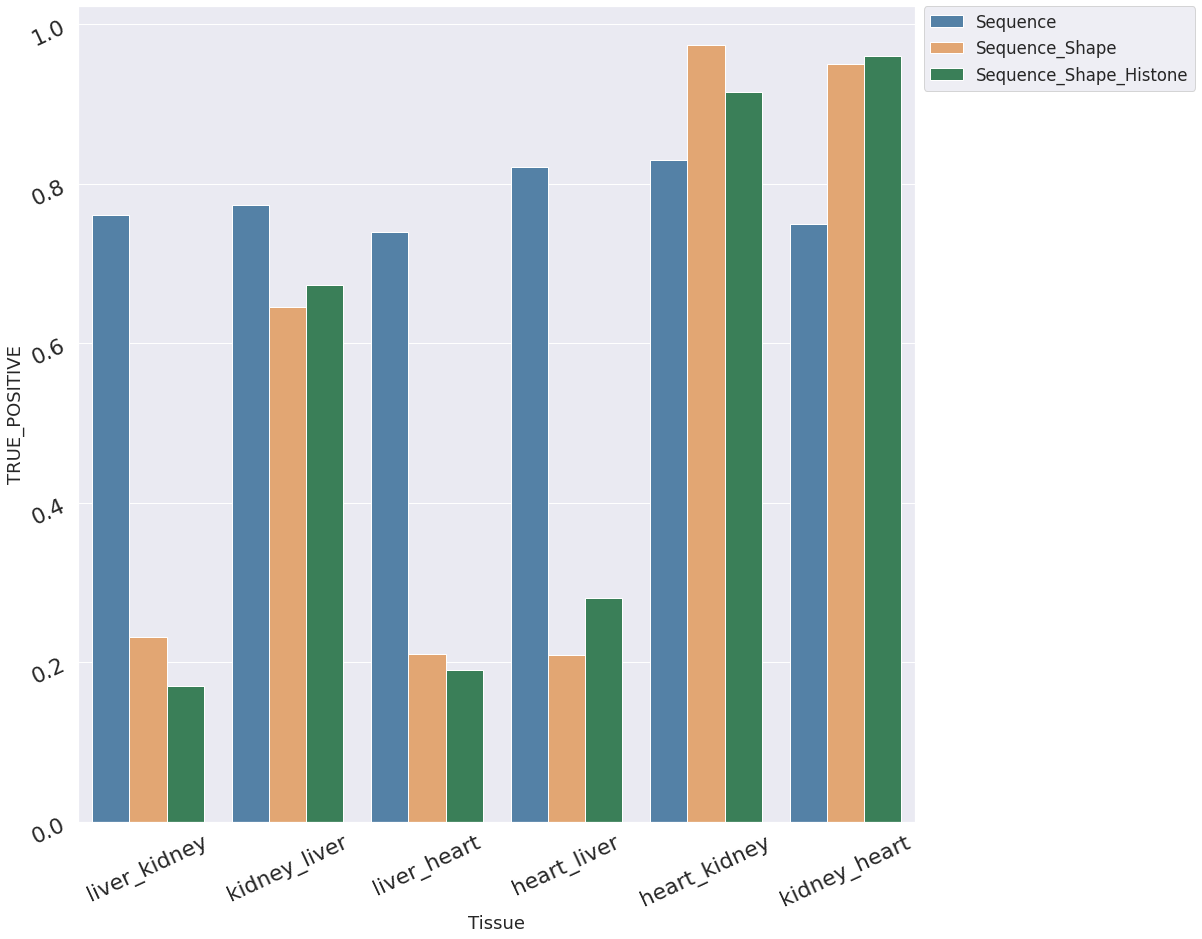

In [12]:
sns.set(font_scale = 1.5,rc={"figure.figsize":(15,15)})
#fig.set_size_inches(15, 15)
my_colors = ['steelblue', 'sandybrown', 'seagreen']
sns.set_palette( my_colors)
sns.barplot(x="Tissue", y="TRUE_POSITIVE", hue="Model", data=TRUE_POSITIVE_DATA, estimator = np.mean)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.xticks(fontsize='large',rotation = 25)
plt.yticks(fontsize='large',rotation = 25)
plt.savefig("CROSS_TRUE_POSITIVE_PERFORMANCES.png")

In [13]:
#False Negative 
FALSE_NEGATIVE_DATA = {'FALSE_NEGATIVE': [0.66, 0.836, 0.911, 0.544, 0.59, 0.84, 0.65, 0.822, 0.88, 0.456, 0.857, 0.905, 0.554, 0.257, 0.43,
                             0.65, 0.425, 0.63], 
                    'Tissue':['liver_kidney','liver_kidney','liver_kidney', 'kidney_liver','kidney_liver','kidney_liver', 'liver_heart',
                              'liver_heart','liver_heart', 'heart_liver', 'heart_liver' , 'heart_liver','heart_kidney','heart_kidney',
                              'heart_kidney', 'kidney_heart','kidney_heart','kidney_heart'  ],
                    'Model':['Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone']}

In [14]:
FALSE_NEGATIVE_DATA  = pd.DataFrame(data = FALSE_NEGATIVE_DATA  )
FALSE_NEGATIVE_DATA 

FALSE_NEGATIVE        Tissue                   Model
0            0.660  liver_kidney                Sequence
1            0.836  liver_kidney          Sequence_Shape
2            0.911  liver_kidney  Sequence_Shape_Histone
3            0.544  kidney_liver                Sequence
4            0.590  kidney_liver          Sequence_Shape
5            0.840  kidney_liver  Sequence_Shape_Histone
6            0.650   liver_heart                Sequence
7            0.822   liver_heart          Sequence_Shape
8            0.880   liver_heart  Sequence_Shape_Histone
9            0.456   heart_liver                Sequence
10           0.857   heart_liver          Sequence_Shape
11           0.905   heart_liver  Sequence_Shape_Histone
12           0.554  heart_kidney                Sequence
13           0.257  heart_kidney          Sequence_Shape
14           0.430  heart_kidney  Sequence_Shape_Histone
15           0.650  kidney_heart                Sequence
16           0.425  kidney_heart          Sequence_Shape
17           0.630  kidney_heart  Sequence_Shape_Histone

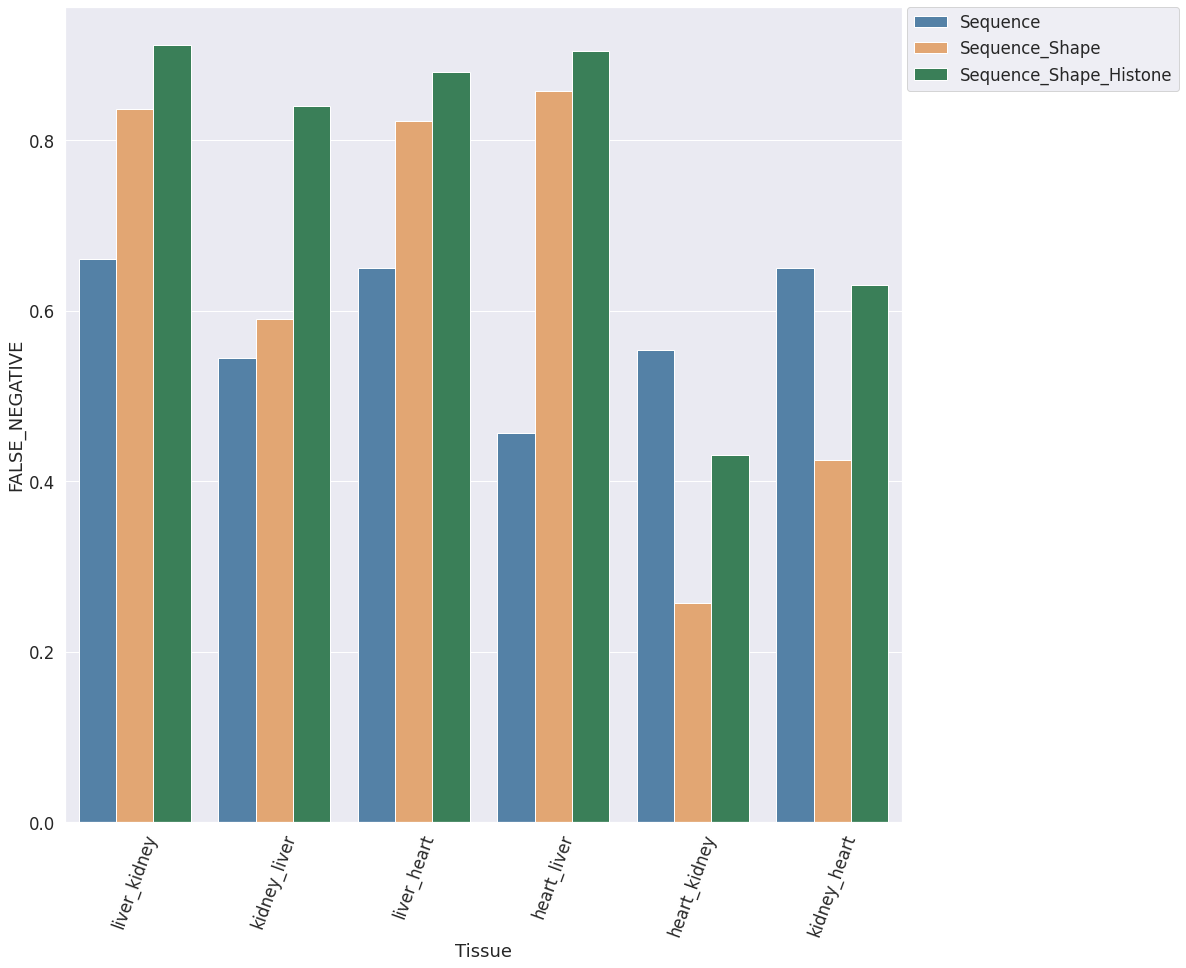

In [16]:
sns.set(font_scale = 1.5,rc={"figure.figsize":(15,15)})
#fig.set_size_inches(15, 15)
my_colors = ['steelblue', 'sandybrown', 'seagreen']
sns.set_palette( my_colors)
sns.barplot(x="Tissue", y="FALSE_NEGATIVE", hue="Model", data=FALSE_NEGATIVE_DATA, estimator = np.mean)
plt.legend(bbox_to_anchor=(1.331, 1),
           borderaxespad=0)
plt.xticks(rotation = 70)
plt.savefig("CROSS_FALSE_NEGATIVE_PERFORMANCES.png")

### 5.3 Cross tissue models accuracy plot

In [17]:
Cross_model_accuracy = {'ACCURACY': [0.76, 0.25, 0.18, 0.77, 0.57, 0.70, 0.74, 0.22, 0.19, 0.81, 0.23, 0.33,0.84,0.97,0.92,0.76,0.93,0.93], 
                    'Tissue':['liver_kidney','liver_kidney','liver_kidney', 'kidney_liver','kidney_liver','kidney_liver', 'liver_heart',
                              'liver_heart','liver_heart', 'heart_liver', 'heart_liver' , 'heart_liver','heart_kidney','heart_kidney',
                              'heart_kidney', 'kidney_heart','kidney_heart','kidney_heart'  ],
                    'Model':['Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone',
                            'Sequence','Sequence_Shape', 'Sequence_Shape_Histone','Sequence','Sequence_Shape', 'Sequence_Shape_Histone']}

In [18]:
Cross_model_accuracy_DATA  = pd.DataFrame(data = Cross_model_accuracy  )
Cross_model_accuracy_DATA 

ACCURACY        Tissue                   Model
0       0.76  liver_kidney                Sequence
1       0.25  liver_kidney          Sequence_Shape
2       0.18  liver_kidney  Sequence_Shape_Histone
3       0.77  kidney_liver                Sequence
4       0.57  kidney_liver          Sequence_Shape
5       0.70  kidney_liver  Sequence_Shape_Histone
6       0.74   liver_heart                Sequence
7       0.22   liver_heart          Sequence_Shape
8       0.19   liver_heart  Sequence_Shape_Histone
9       0.81   heart_liver                Sequence
10      0.23   heart_liver          Sequence_Shape
11      0.33   heart_liver  Sequence_Shape_Histone
12      0.84  heart_kidney                Sequence
13      0.97  heart_kidney          Sequence_Shape
14      0.92  heart_kidney  Sequence_Shape_Histone
15      0.76  kidney_heart                Sequence
16      0.93  kidney_heart          Sequence_Shape
17      0.93  kidney_heart  Sequence_Shape_Histone

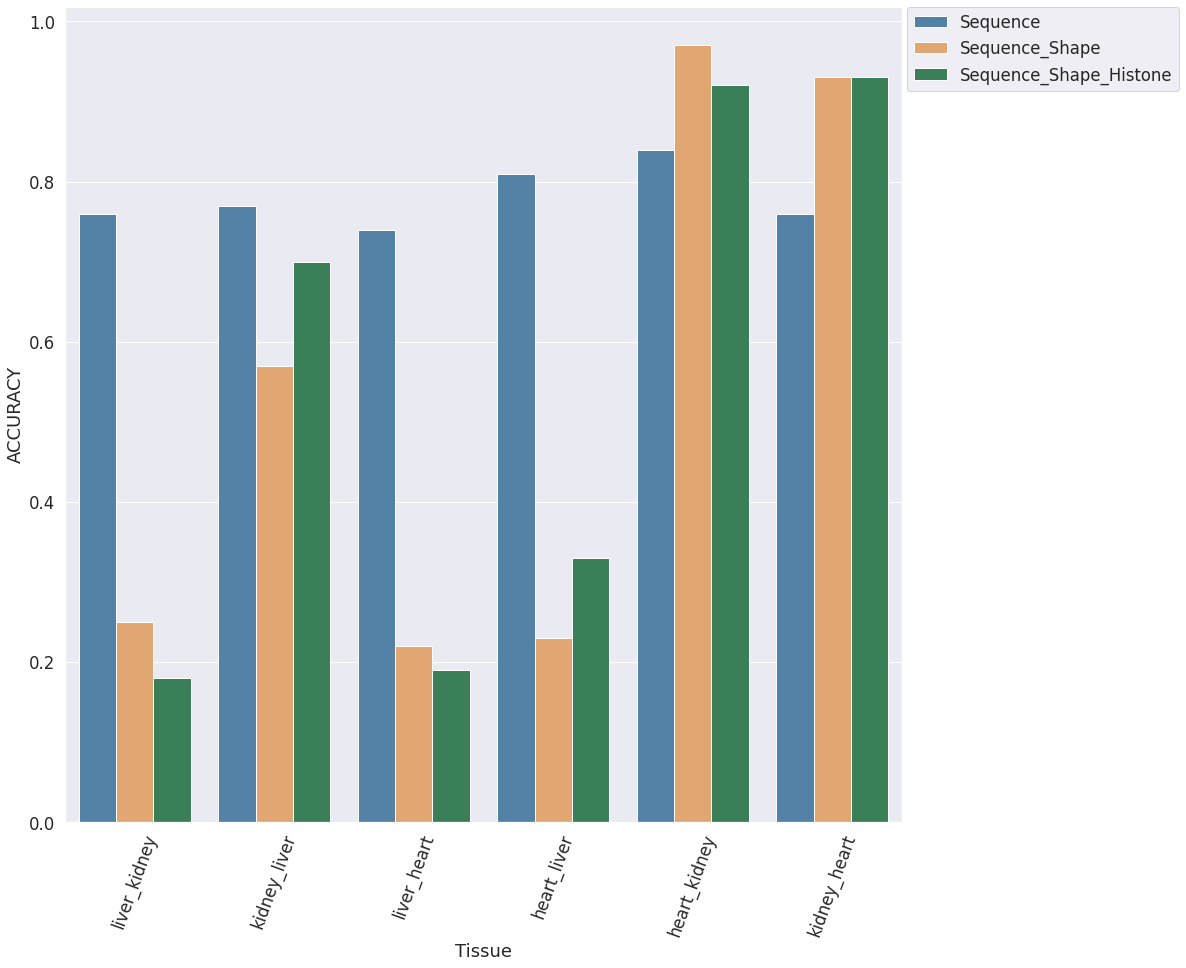

In [20]:
sns.set(font_scale = 1.5,rc={"figure.figsize":(15, 15)})
#fig.set_size_inches(15, 15)
my_colors = ['steelblue', 'sandybrown', 'seagreen']
sns.set_palette( my_colors)
sns.barplot(x="Tissue", y="ACCURACY", hue="Model", data=Cross_model_accuracy_DATA, estimator = np.mean)
plt.legend(bbox_to_anchor=(1.331, 1),
           borderaxespad=0)
plt.xticks(rotation = 70)
plt.savefig("CROSS_TISSUE_ACCURACY_PERFORMANCES.png")

### 6 Within tissue model plots

### 6.1 Within tissue accuracy plot

In [23]:
Accuracy= {'ACCURACY': [0.76, 0.93, 0.95, 0.79, 0.95, 0.92,0.84, 0.97, 0.97], 
                    'Tissue':['liver','liver','liver', 'kidney','kidney','kidney', 'heart',
                              'heart','heart'],
                    'Model':['Sequence','Sequence + Shape', 'Sequence + Shape + Histone modification','Sequence','Sequence + Shape', 'Sequence + Shape + Histone modification',
                            'Sequence','Sequence + Shape', 'Sequence + Shape + Histone modification',]}

In [24]:
Accuracy_DATA  = pd.DataFrame(data = Accuracy  )
Accuracy_DATA 

ACCURACY  Tissue                                    Model
0      0.76   liver                                 Sequence
1      0.93   liver                         Sequence + Shape
2      0.95   liver  Sequence + Shape + Histone modification
3      0.79  kidney                                 Sequence
4      0.95  kidney                         Sequence + Shape
5      0.92  kidney  Sequence + Shape + Histone modification
6      0.84   heart                                 Sequence
7      0.97   heart                         Sequence + Shape
8      0.97   heart  Sequence + Shape + Histone modification

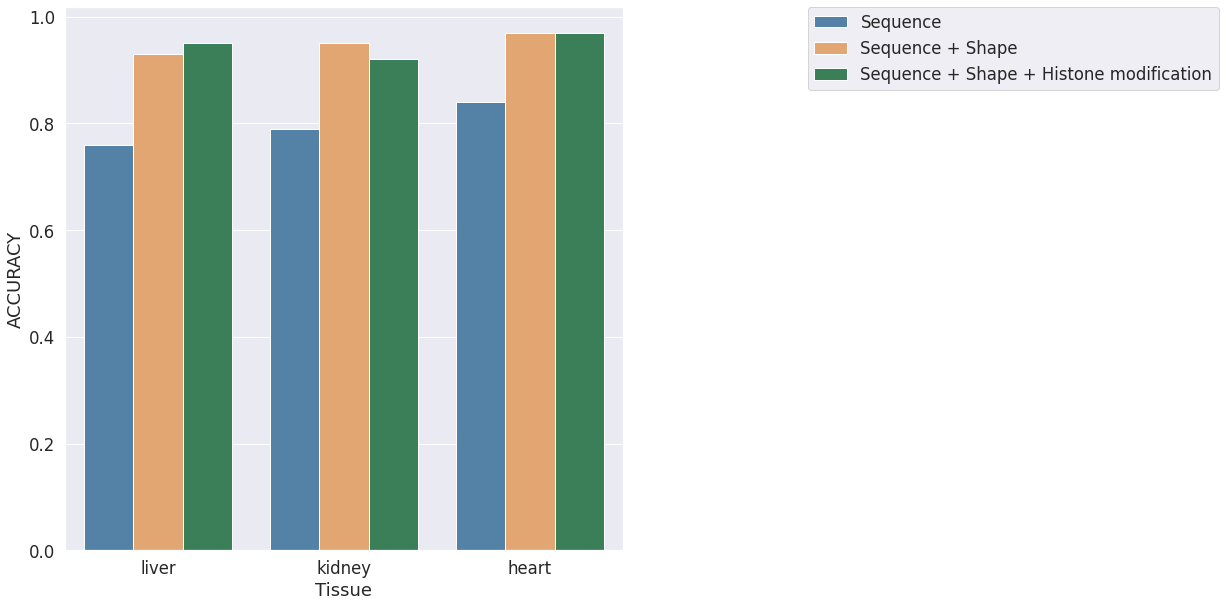

In [25]:
#sns.set(font_scale = 1.5,rc={"figure.figsize":(15, 15)})
fig, ax = plt.subplots(figsize=(10, 10))
my_colors = ['steelblue', 'sandybrown', 'seagreen']
sns.set_palette( my_colors)
sns.barplot(x="Tissue", y="ACCURACY", hue="Model", data=Accuracy_DATA, estimator = np.mean)
plt.legend(bbox_to_anchor=(1.331, 1),
           borderaxespad=0)
plt.xticks(rotation = 0)
plt.savefig("MODEL_ACCURACY_PERFORMANCES.png")

### 6.2 Within tissue AUROC & AUPRC plot

In [29]:
# AUROC
Auroc_data = {'AUROC': [0.7053334437829856, 0.7138714084330532, 0.7259382980817364, 0.7052280703866052, 0.7012667882588923,
                        0.9756057782868374, 0.9739320971614399, 0.9773599500414551, 0.9765411141973319, 0.9740773847664672,
                       0.9924228352531925, 0.9902204519917217, 0.9892105190491733, 0.9878644846148781, 0.9889961808901485,
                       0.7990513660059977, 0.7713324983956759, 0.7879018252978915, 0.7760977224919379, 0.770791300665927,
                       0.9401075649934502, 0.9550537236643782, 0.9463271172265034, 0.9317988097173049, 0.947610483344758,
                       0.966745038037103, 0.9617922686156972, 0.9552829338980687, 0.9689502403885792, 0.9635029097500476,
                       0.8183718499328765, 0.8111249562237344, 0.8023935780739277, 0.7780302013756362, 0.807382921050539,
                       0.9942397078872323, 0.9969568329539391, 0.9994391817382097, 0.9997664855572854, 0.9998846487042988,
                       0.9945347416783403, 0.9936172641084651, 0.9959462005328197, 0.9927403884382952, 0.9959404714075264], 
              'Tissue':['liver','liver','liver','liver','liver','liver','liver','liver','liver','liver','liver','liver',
                       'liver','liver','liver','kidney','kidney','kidney','kidney','kidney','kidney','kidney','kidney','kidney','kidney',
                       'kidney','kidney','kidney','kidney','kidney','heart','heart','heart','heart','heart','heart','heart','heart','heart','heart',
                       'heart','heart','heart','heart','heart'], 
              'Model':['Sequence','Sequence','Sequence','Sequence','Sequence','Sequence_Shape',
                       'Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape',
                      'Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone',
                      'Sequence','Sequence','Sequence','Sequence','Sequence',
                      'Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape',
                      'Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone',
                      'Sequence','Sequence','Sequence','Sequence','Sequence',
                      'Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape',
                      'Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone'] }

In [30]:
Auroc_data  = pd.DataFrame(data =Auroc_data )
Auroc_data 

AUROC  Tissue                   Model
0   0.705333   liver                Sequence
1   0.713871   liver                Sequence
2   0.725938   liver                Sequence
3   0.705228   liver                Sequence
4   0.701267   liver                Sequence
5   0.975606   liver          Sequence_Shape
6   0.973932   liver          Sequence_Shape
7   0.977360   liver          Sequence_Shape
8   0.976541   liver          Sequence_Shape
9   0.974077   liver          Sequence_Shape
10  0.992423   liver  Sequence_Shape_Histone
11  0.990220   liver  Sequence_Shape_Histone
12  0.989211   liver  Sequence_Shape_Histone
13  0.987864   liver  Sequence_Shape_Histone
14  0.988996   liver  Sequence_Shape_Histone
15  0.799051  kidney                Sequence
16  0.771332  kidney                Sequence
17  0.787902  kidney                Sequence
18  0.776098  kidney                Sequence
19  0.770791  kidney                Sequence
20  0.940108  kidney          Sequence_Shape
21  0.955054  kidney          Sequence_Shape
22  0.946327  kidney          Sequence_Shape
23  0.931799  kidney          Sequence_Shape
24  0.947610  kidney          Sequence_Shape
25  0.966745  kidney  Sequence_Shape_Histone
26  0.961792  kidney  Sequence_Shape_Histone
27  0.955283  kidney  Sequence_Shape_Histone
28  0.968950  kidney  Sequence_Shape_Histone
29  0.963503  kidney  Sequence_Shape_Histone
30  0.818372   heart                Sequence
31  0.811125   heart                Sequence
32  0.802394   heart                Sequence
33  0.778030   heart                Sequence
34  0.807383   heart                Sequence
35  0.994240   heart          Sequence_Shape
36  0.996957   heart          Sequence_Shape
37  0.999439   heart          Sequence_Shape
38  0.999766   heart          Sequence_Shape
39  0.999885   heart          Sequence_Shape
40  0.994535   heart  Sequence_Shape_Histone
41  0.993617   heart  Sequence_Shape_Histone
42  0.995946   heart  Sequence_Shape_Histone
43  0.992740   heart  Sequence_Shape_Histone
44  0.995940   heart  Sequence_Shape_Histone

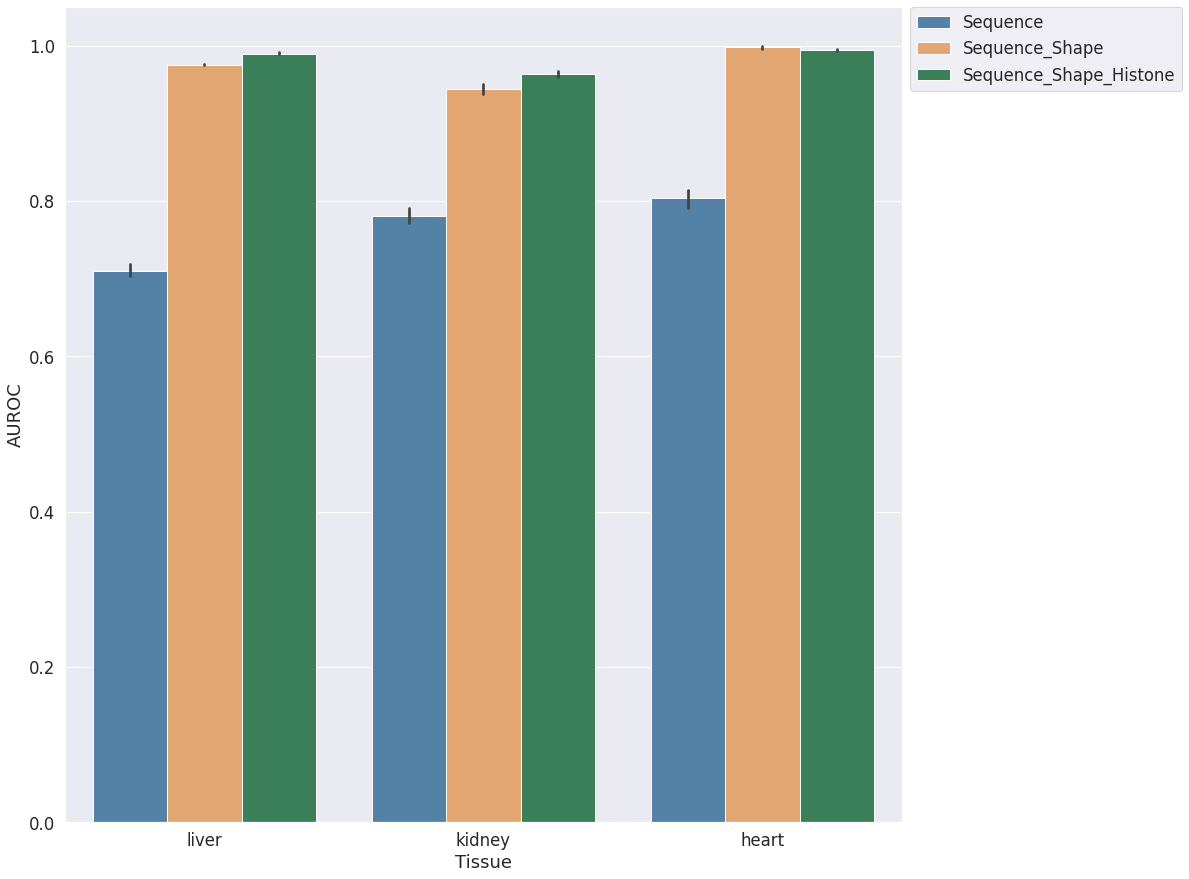

In [31]:

my_colors = ['steelblue', 'sandybrown', 'seagreen']
sns.set_palette( my_colors)
sns.barplot(x="Tissue", y="AUROC", hue="Model", data=Auroc_data,estimator = np.mean)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.savefig("ALL_AUROC_PERFORMANCES.png")

In [32]:
# AUPRC
Auprc_data = {'AUPRC': [0.08952673150605148, 0.08741478722918794, 0.09804556748523809, 0.07941328678785439, 0.09503985553114609,
                        0.7889417134601919, 0.7867438636627658, 0.7958434665081578, 0.8001709874948527, 0.792504335163512,
                       0.9435267296983288, 0.9527162448848441, 0.9572837671221174, 0.9466596661776268, 0.9493662511604184,
                       0.09601419671023152, 0.10645319723624871, 0.10207592345907285, 0.10076480646545796, 0.10792951505580133,
                       0.4693158093247867, 0.4925717811478081, 0.4778595159926168, 0.4652603773497672, 0.514340646103229,
                       0.6381907589392309, 0.671901013154035, 0.6277737615507721, 0.6201592961193818, 0.6832678795908103,
                       0.06640822455009816, 0.06340693715015079, 0.05283470270354913, 0.049816596439226424, 0.049732930797600966,
                       0.7579167674329604, 0.727000031803061, 0.6788174779604602, 0.6317855481016441, 0.7305221094279193,
                       0.766953991518599, 0.8090665801689667, 0.7917084337176111, 0.8031693574525881, 0.7373577367681475], 
              'Tissue':['liver','liver','liver','liver','liver','liver','liver','liver','liver','liver','liver','liver',
                       'liver','liver','liver','kidney','kidney','kidney','kidney','kidney','kidney','kidney','kidney','kidney','kidney',
                       'kidney','kidney','kidney','kidney','kidney','heart','heart','heart','heart','heart','heart','heart','heart','heart','heart',
                       'heart','heart','heart','heart','heart'], 
              'Model':['Sequence','Sequence','Sequence','Sequence','Sequence','Sequence_Shape',
                       'Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape',
                      'Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone',
                      'Sequence','Sequence','Sequence','Sequence','Sequence',
                      'Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape',
                      'Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone',
                      'Sequence','Sequence','Sequence','Sequence','Sequence',
                      'Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape','Sequence_Shape',
                      'Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone','Sequence_Shape_Histone'] }

In [33]:
Auprc_data  = pd.DataFrame(data =Auprc_data )
Auprc_data 

AUPRC  Tissue                   Model
0   0.089527   liver                Sequence
1   0.087415   liver                Sequence
2   0.098046   liver                Sequence
3   0.079413   liver                Sequence
4   0.095040   liver                Sequence
5   0.788942   liver          Sequence_Shape
6   0.786744   liver          Sequence_Shape
7   0.795843   liver          Sequence_Shape
8   0.800171   liver          Sequence_Shape
9   0.792504   liver          Sequence_Shape
10  0.943527   liver  Sequence_Shape_Histone
11  0.952716   liver  Sequence_Shape_Histone
12  0.957284   liver  Sequence_Shape_Histone
13  0.946660   liver  Sequence_Shape_Histone
14  0.949366   liver  Sequence_Shape_Histone
15  0.096014  kidney                Sequence
16  0.106453  kidney                Sequence
17  0.102076  kidney                Sequence
18  0.100765  kidney                Sequence
19  0.107930  kidney                Sequence
20  0.469316  kidney          Sequence_Shape
21  0.492572  kidney          Sequence_Shape
22  0.477860  kidney          Sequence_Shape
23  0.465260  kidney          Sequence_Shape
24  0.514341  kidney          Sequence_Shape
25  0.638191  kidney  Sequence_Shape_Histone
26  0.671901  kidney  Sequence_Shape_Histone
27  0.627774  kidney  Sequence_Shape_Histone
28  0.620159  kidney  Sequence_Shape_Histone
29  0.683268  kidney  Sequence_Shape_Histone
30  0.066408   heart                Sequence
31  0.063407   heart                Sequence
32  0.052835   heart                Sequence
33  0.049817   heart                Sequence
34  0.049733   heart                Sequence
35  0.757917   heart          Sequence_Shape
36  0.727000   heart          Sequence_Shape
37  0.678817   heart          Sequence_Shape
38  0.631786   heart          Sequence_Shape
39  0.730522   heart          Sequence_Shape
40  0.766954   heart  Sequence_Shape_Histone
41  0.809067   heart  Sequence_Shape_Histone
42  0.791708   heart  Sequence_Shape_Histone
43  0.803169   heart  Sequence_Shape_Histone
44  0.737358   heart  Sequence_Shape_Histone

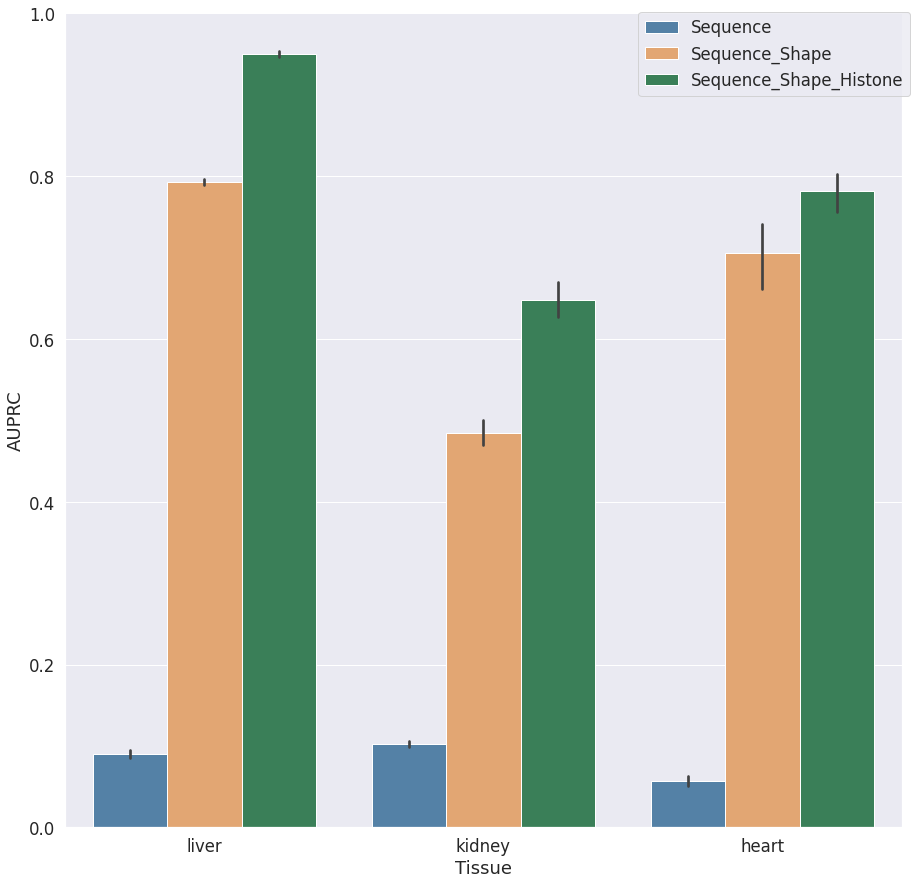

In [34]:
my_colors = ['steelblue', 'sandybrown', 'seagreen']
sns.set_palette( my_colors)
sns.barplot(x="Tissue", y="AUPRC", hue="Model", data=Auprc_data)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.savefig("ALL_AUPRC_PERFORMANCES.png")